# Análisis Exploratorio de Datos (E.D.A)

#### María Agostina Balverde Moll - DATA FT 11

#### MOOCs

Una startup de tecnología está interesada en sumarse al mercado de cursos online, pero de una manera eficiente, por lo que compró datasets de posibles competidores para analizar y sacar conclusiones de los datos recolectados.

Solicitan:
* Segmentar el nivel de ventas según precio, idioma, nivel y rating de cada curso, con el objetivo analizar qué tanto influyen dichas variables en la demanda del producto vendido.
* Word Cloud de las palabras clave que más se repiten dentro del título -se pueden añadir otras variables de nuestro interés-.
* Visualizar: Tasa de conversión de inscriptos gratuitos a inscriptos pagados -calculado como el número de inscriptos en cursos pagados / número de inscriptos en cursos gratuitos * 100,  y establecer otros tres KPIs producto de su análisis y que se puedan visualizar en el dashboard.

Objetivo empresarial: 
* Evaluar si en la tendencia se logra incrementar esta tasa en un 15% en comparación con el año anterior.

In [1]:
#Importo las librerías a utilizar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re
from nltk.tokenize import word_tokenize
from scipy.stats import chi2_contingency
import seaborn as sns
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
import spacy
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


-----------------------------------------
### REVISIÓN DE LOS DATOS DE COURSERA

In [8]:
#Convierto a dataframes el primer archivo de coursera

cursos_coursera = pd.read_csv('Datasets/Coursera_courses.csv')

In [9]:
#Reviso el dataframe de coursera para ver su estructura general

cursos_coursera.head(1)

name          institution  \
0  Machine Learning  Stanford University   

                                        course_url         course_id  
0  https://www.coursera.org/learn/machine-learning  machine-learning

In [10]:
#Obtengo información detallada del dataframe cursos_coursera

cursos_coursera.dtypes

name           object
institution    object
course_url     object
course_id      object
dtype: object

In [11]:
#Elimino la columna course_url
cursos_coursera = cursos_coursera.drop('course_url',1)

#Reviso que se elimine
cursos_coursera.head(1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\62578980.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cursos_coursera = cursos_coursera.drop('course_url',1)


name          institution         course_id
0  Machine Learning  Stanford University  machine-learning

In [12]:
#Reviso si tiene datos duplicados en la columna id

duplicados = cursos_coursera['course_id'].duplicated(keep=False)
cantidad_duplicados = duplicados.sum()
print(cantidad_duplicados)

0


In [13]:
#Cuento la cantidad de valores por institución

instituciones = cursos_coursera['institution'].value_counts()

print (instituciones)

University of Pennsylvania       43
University of Michigan           31
Duke University                  24
Google Cloud                     22
IBM                              18
                                 ..
EDHEC Business School             1
INSEAD                            1
Google - Spectrum Sharing         1
New York Institute of Finance     1
UCL School of Management          1
Name: institution, Length: 134, dtype: int64


In [14]:
#creo el dataframe para el segundo csv de Coursera
reviews_coursera = pd.read_csv('Datasets/Coursera_reviews.csv')

In [15]:
#Reviso el segundo dataframe de coursera para ver su estructura general

reviews_coursera.head(1)

reviews    reviewers  \
0  Pretty dry, but I was able to pass with just t...  By Robert S   

   date_reviews  rating                 course_id  
0  Feb 12, 2020       4  google-cbrs-cpi-training

In [16]:
#Consulto los tipos de datos por columna
reviews_coursera.dtypes

reviews         object
reviewers       object
date_reviews    object
rating           int64
course_id       object
dtype: object

In [17]:
#Paso date_reviews a datetime y obtengo año y mes de las mismas

reviews_coursera['date_reviews'] = pd.to_datetime(reviews_coursera['date_reviews'])

reviews_coursera['year'] = reviews_coursera['date_reviews'].dt.year

reviews_coursera['month'] = reviews_coursera['date_reviews'].dt.month

In [18]:
#Paso la columna rating a variable categórica

reviews_coursera['rating'] = reviews_coursera['rating'].astype('category')

In [19]:
#Reviso que se haya aplicado
reviews_coursera.dtypes

reviews                 object
reviewers               object
date_reviews    datetime64[ns]
rating                category
course_id               object
year                     int64
month                    int64
dtype: object

In [20]:
#Elimino la columna date_reviews

reviews_coursera = reviews_coursera.drop('date_reviews',1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\2822498320.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  reviews_coursera = reviews_coursera.drop('date_reviews',1)


In [21]:
reviews_coursera.head(1)

reviews    reviewers rating  \
0  Pretty dry, but I was able to pass with just t...  By Robert S      4   

                  course_id  year  month  
0  google-cbrs-cpi-training  2020      2

In [22]:
#Reviso si la columna reviewers tiene datos duplicados

duplicados = reviews_coursera.duplicated(['reviewers'],keep=False)
cantidad_duplicados = duplicados.sum()
print(cantidad_duplicados)

1431064


Puede que hayan alumnos que han cursado en varios cursos, dado que se repiten sus nombres/usuarios

In [23]:
#Reviso si la columna reviews tiene datos duplicados

duplicados = reviews_coursera.duplicated(['reviews'],keep=False)
cantidad_duplicados = duplicados.sum()
print(cantidad_duplicados)

1411528


In [24]:
#Cuento las repeticiones de 'Great course'
count = reviews_coursera['reviews'].str.count('Great course').sum()

print("Número de repeticiones de 'Great course':", count)

Número de repeticiones de 'Great course': 44859.0


Revisando las celdas, hay comentarios que son exactamente iguales. Por ejemplo 'great course'. Por lo tanto no elimino los duplicados y tampoco los faltantes ya que pueden ser filas que sean útiles para otro análisis. 

In [25]:
#Uno ambos dataframes

coursera = pd.merge(cursos_coursera,reviews_coursera, on = 'course_id')

In [26]:
coursera

name                      institution  \
0           Machine Learning              Stanford University   
1           Machine Learning              Stanford University   
2           Machine Learning              Stanford University   
3           Machine Learning              Stanford University   
4           Machine Learning              Stanford University   
...                      ...                              ...   
1454706  Managing as a Coach  University of California, Davis   
1454707  Managing as a Coach  University of California, Davis   
1454708  Managing as a Coach  University of California, Davis   
1454709  Managing as a Coach  University of California, Davis   
1454710  Managing as a Coach  University of California, Davis   

                   course_id  \
0           machine-learning   
1           machine-learning   
2           machine-learning   
3           machine-learning   
4           machine-learning   
...                      ...   
1454706  managing-as-a-coach   
1454707  managing-as-a-coach   
1454708  managing-as-a-coach   
1454709  managing-as-a-coach   
1454710  managing-as-a-coach   

                                                   reviews     reviewers  \
0        This is an extremely basic course. Machine lea...  By Deleted A   
1        The course is ok but the certification procedu...    By Bruno C   
2        I just started week 3 , I have to admit that I...       By Fadi   
3        This course is absolute garbage.  You get no f...   By Mathew L   
4        However good the material and lectures may be,...      By Rui C   
...                                                    ...           ...   
1454706                                                 re   By Sachin M   
1454707                                                  E      By Denis   
1454708                                                  G     By Neil B   
1454709                                                  E   By Isaias M   
1454710                                                  .  By Antonio M   

        rating  year  month  
0            1  2017      3  
1            1  2015     11  
2            1  2019      4  
3            1  2015      9  
4            1  2015     12  
...        ...   ...    ...  
1454706      5  2017     10  
1454707      5  2019      3  
1454708      5  2018     10  
1454709      5  2016      8  
1454710      5  2016      2  

[1454711 rows x 8 columns]

ANÁLISIS UNIVARIABLE

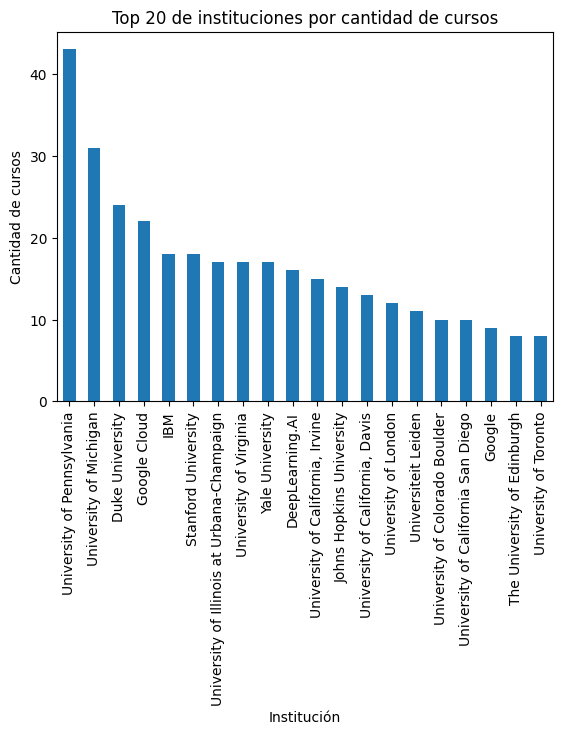

In [27]:
#HIPÓTESIS 1: La popularidad o elección de un MOOC en Coursera es mayor si lo dicta una universidad
#Realizo un histograma para revisar el top 20 de cursos por institución

counts = cursos_coursera['institution'].value_counts().head(20)

counts.plot(kind='bar')
plt.xlabel('Institución')
plt.ylabel('Cantidad de cursos')
plt.title('Top 20 de instituciones por cantidad de cursos')
plt.show()

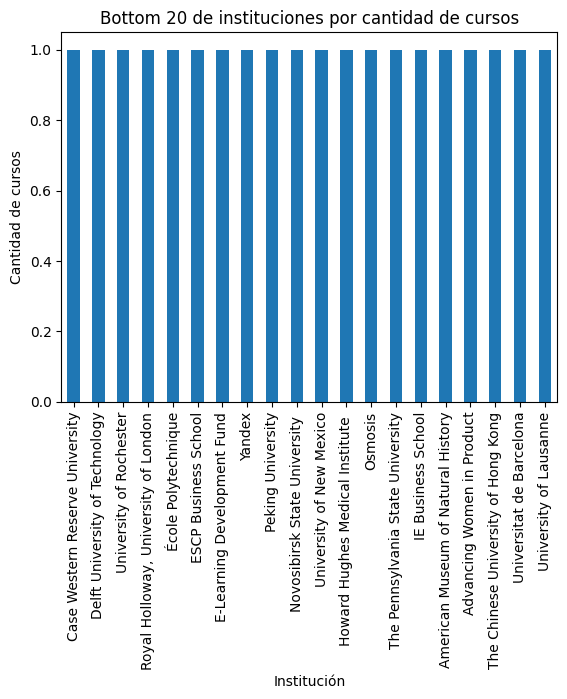

In [28]:
#Repito pero para ver el bottom 20
counts = cursos_coursera['institution'].value_counts()

bottom_20 = counts.nsmallest(20)

bottom_20.plot(kind='bar')
plt.xlabel('Institución')
plt.ylabel('Cantidad de cursos')
plt.title('Bottom 20 de instituciones por cantidad de cursos')
plt.show()

Primer hipótesis refutada: "La popularidad o elección de un MOOC en Coursera es mayor si lo dicta una universidad"

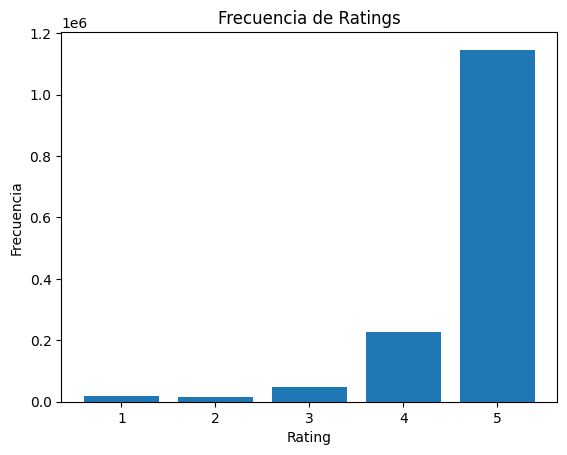

In [29]:
#Cuento la cantidad de cursos valuados en distintos ratings (1 al 5)
contador = coursera['rating'].value_counts()

#Creo el gráfico de barras
plt.bar(contador.index, contador.values)
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Ratings')
plt.show()

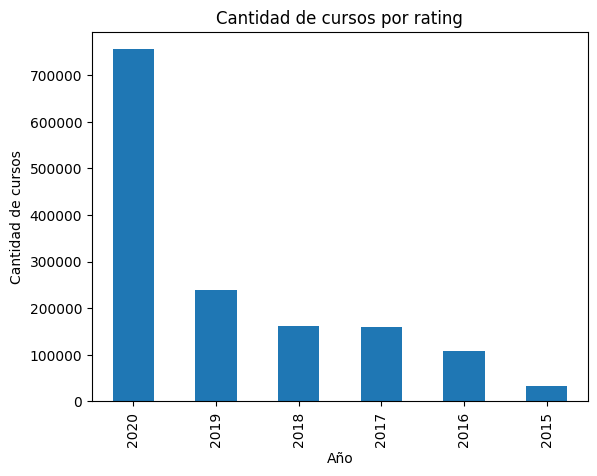

In [30]:
#HIPÓTESIS: La popularidad de los MOOCs creció a partir del año 2020

contador = coursera ['year'].value_counts()

#Grafico el conteo
contador.plot(kind='bar')
plt.xlabel('Año')
plt.ylabel('Cantidad de cursos')
plt.title('Cantidad de cursos por rating')
plt.show()

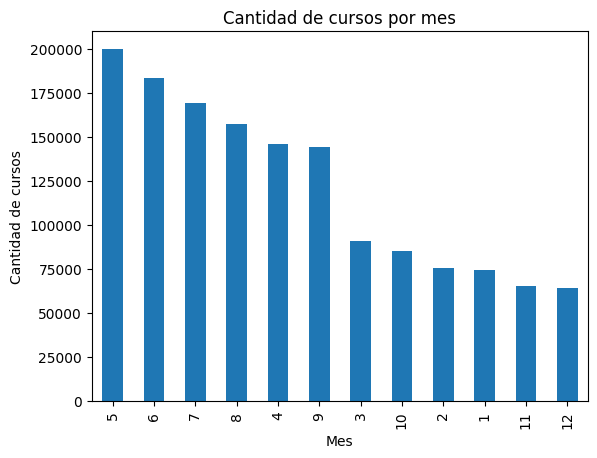

In [31]:
#Cuento la cantidad de cursos valuados por mes
contador = coursera ['month'].value_counts()

#Grafico el conteo
contador.plot(kind='bar')
plt.xlabel('Mes')
plt.ylabel('Cantidad de cursos')
plt.title('Cantidad de cursos por mes')
plt.show()

CONCLUSIONES

* La popularidad de los MOOCs creció a partir del año 2020
* Puede que hayan alumnos que han cursado en varios cursos, dado que se repiten sus nombres/usuarios
* Revisando las celdas de reviews, hay comentarios que son exactamente iguales. Por ejemplo 'great course'.
* Los cursos de coursera tienen mayoria de rating = 5, se deberá analizar de dónde proviene esa popularidad (opciones: temas abordados, títulos, institución que los dicta, mes en el que se cursó y otras variables aún no encontradas)
* Los meses en los que la mayoría de las personas inician cursos son entre Abril y Septiembre, es decir, del segundo al tercer trimestre
* Hay 1431064 reviewers duplicados, lo que puede implicar que una persona dejó comentarios en más de 1 curso. Según lo investigado en internet, una persona puede dejar su comentario/review en un curso de Coursera sin necesariamente haber terminado el curso, pero si debe haberse inscripto. 
* En cuanto a los comentarios, hay 1411528 duplicados. Por ejemplo 'Great course'. Pero decido no eliminar los duplicados y tampoco los faltantes de esta variable, ya que pueden ser filas que sean útiles para otro análisis. 

ANÁLISIS MULTIVARIABLE

In [32]:
#Cuento los id únicos

total_id = coursera['course_id'].nunique()
print("Total de id en la columna 'course_id':", total_id)


Total de id en la columna 'course_id': 604


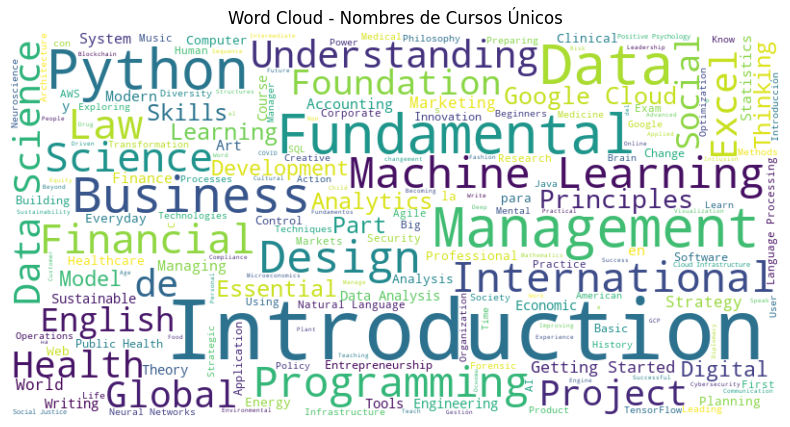

In [33]:
#Creo un Word Cloud para los nombres de los cursos

nombres_unicos = coursera['name'].unique()
text_nombres_unicos = ' '.join(nombres_unicos) #Concateno los nombres únicos en un sólo texto

#Creo el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_nombres_unicos)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Nombres de Cursos Únicos")
plt.show()


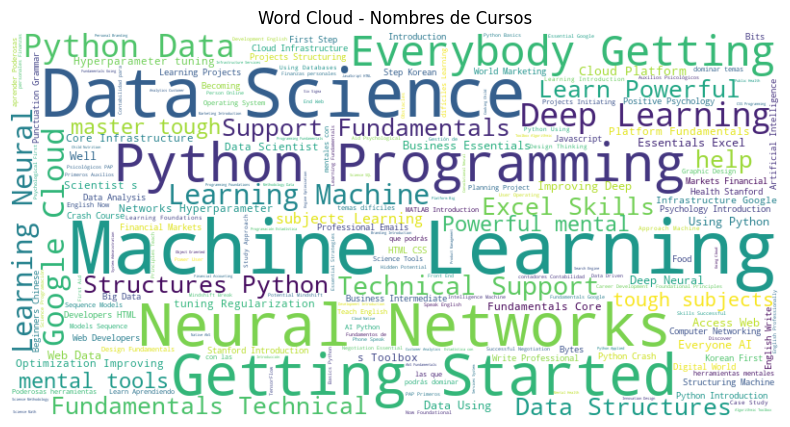

In [34]:
#Creo una nube de palabras con todos los títulos (contando los todos los cursos)

text_nombres_cursos = ' '.join(coursera['name'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_nombres_cursos)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Nombres de Cursos")
plt.show()



In [37]:
#Cuento la cantidad de reviewers por curso

reviewers_count = coursera.groupby(['name', 'course_id'])['reviewers'].transform('count')
coursera['reviewers_count'] = reviewers_count

In [38]:
#Elimino la columna reviewers y reviews
coursera = coursera.drop('reviewers',1)
coursera = coursera.drop('reviews',1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\1723832106.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  coursera = coursera.drop('reviewers',1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\1723832106.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  coursera = coursera.drop('reviews',1)


In [36]:
#Top 5 y bottom 5 en términos de reviews
coursera.name.value_counts()

Programming for Everybody (Getting Started with Python)    45218
Machine Learning                                           35895
Neural Networks and Deep Learning                          35750
Technical Support Fundamentals                             35319
Python Data Structures                                     33546
                                                           ...  
Social and Economic Networks:  Models and Analysis             6
Entreprise et changement climatique                            6
Epigenetic Control of Gene Expression                          6
Introduction to Healthcare                                     6
Building Modern Python Applications on AWS                     3
Name: name, Length: 603, dtype: int64

In [35]:
#Defino una función que calcula, en una columna adicional (Proporción Rating), la proporción de 5 en el rating de un curso

def calcular_proporcion_rating_perfecto(curso):
    data = coursera[coursera['name'] == curso]
    proporcion = data[data['rating'] == 5]['rating'].count() / data['rating'].count()
    return proporcion

#Defino una funcion que extrae el valor de la proporción 
def myFunc(e):
    
    return e['ratio']

#Listado de todos los cursos únicos
nombre_cursos = list(coursera.name.unique())


lista_proporciones = [(curso, calcular_proporcion_rating_perfecto(curso)) for curso in nombre_cursos]
lista_proporciones.sort(key=lambda x: x[1], reverse=True)



In [39]:
top_10_cursos = lista_proporciones[:10] #Top 10 cursos con la mayor cantidad de rating de 5 

print("Top 10 cursos con la mayor cantidad de calificaciones 5:")
for curso, proporcion in top_10_cursos:
    print(f"Curso: {curso}, Proporción de calificaciones 5: {proporcion}")


Top 10 cursos con la mayor cantidad de calificaciones 5:
Curso: How to Manage a Remote Team, Proporción de calificaciones 5: 1.0
Curso: Entreprise et changement climatique, Proporción de calificaciones 5: 1.0
Curso: Building Modern Python Applications on AWS, Proporción de calificaciones 5: 1.0
Curso: Removing Barriers to Change, Proporción de calificaciones 5: 1.0
Curso: The Horse Course: Introduction to Basic Care and Management, Proporción de calificaciones 5: 0.9728682170542635
Curso: Economics of Money and Banking, Proporción de calificaciones 5: 0.9704797047970479
Curso: Programming Languages, Part A, Proporción de calificaciones 5: 0.9690627843494085
Curso: El Abogado del Futuro: Legaltech y la Transformación Digital del Derecho, Proporción de calificaciones 5: 0.968
Curso: In the Studio: Postwar Abstract Painting, Proporción de calificaciones 5: 0.9668989547038328
Curso: More Introduction to Financial Accounting, Proporción de calificaciones 5: 0.9662921348314607


In [40]:
lista_proporciones.sort(key=lambda x: x[1])

bottom_10_cursos = lista_proporciones[:10] #Bottom 10 con la menor cantidad de rating de 5

print("Bottom 10 cursos con la menor cantidad de calificaciones 5:")
for curso, proporcion in bottom_10_cursos:
    print(f"Curso: {curso}, Proporción de calificaciones 5: {proporcion}")

Bottom 10 cursos con la menor cantidad de calificaciones 5:
Curso: Introduction to Healthcare, Proporción de calificaciones 5: 0.0
Curso: Entrepreneurship Strategy: From Ideation to Exit, Proporción de calificaciones 5: 0.0
Curso: Epigenetic Control of Gene Expression, Proporción de calificaciones 5: 0.0
Curso: Spanish for Successful Communication in Healthcare Settings, Proporción de calificaciones 5: 0.0
Curso: The Introduction to Quantum Computing, Proporción de calificaciones 5: 0.0
Curso: Social and Economic Networks:  Models and Analysis, Proporción de calificaciones 5: 0.0
Curso: Curanderismo: Traditional Healing Using Plants, Proporción de calificaciones 5: 0.0
Curso: Introduction to HTML5, Proporción de calificaciones 5: 0.14147130153597412
Curso: Convolutional Neural Networks, Proporción de calificaciones 5: 0.20080321285140562
Curso: Introduction to Trading, Machine Learning & GCP, Proporción de calificaciones 5: 0.24456521739130435


In [41]:
coursera.head(1)

name          institution         course_id rating  year  \
0  Machine Learning  Stanford University  machine-learning      1  2017   

   month  reviewers_count  
0      3            35895

In [43]:
#Categorizo por tema los id

nltk.download('stopwords')
nltk.download('punkt')

#Creo una lista con los id de los cursos
course_id = coursera['course_id'].tolist()

#Inicializo el objeto TfidfVectorizer para convertir el texto en vectores numéricos
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stopwords.words('spanish'))
X = vectorizer.fit_transform(course_id)

#Inicializo el objeto KMeans para agrupar los id en categorías
kmeans = KMeans(n_clusters=20)  #Ajusto el número de clusters a 20
kmeans.fit(X)

#Obtengo las etiquetas asignadas a cada id
labels = kmeans.labels_

#Creo una nueva columna en el DataFrame para almacenar las categorías asignadas
coursera['categoria'] = labels

#Obtengo la cantidad de categorías creadas para verificar
cantidad_categorias = coursera['categoria'].nunique()

print("Cantidad de categorías:", cantidad_categorias)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cantidad de categorías: 20


In [44]:
coursera.head()

name          institution         course_id rating  year  \
0  Machine Learning  Stanford University  machine-learning      1  2017   
1  Machine Learning  Stanford University  machine-learning      1  2015   
2  Machine Learning  Stanford University  machine-learning      1  2019   
3  Machine Learning  Stanford University  machine-learning      1  2015   
4  Machine Learning  Stanford University  machine-learning      1  2015   

   month  reviewers_count  categoria  
0      3            35895          1  
1     11            35895          1  
2      4            35895          1  
3      9            35895          1  
4     12            35895          1

In [45]:
#Veo el listado de títulos de cada categoría

categorias = coursera['categoria'].unique()[:20]

for categoria in categorias:
    nombres_unicos = coursera[coursera['categoria'] == categoria]['course_id'].unique()
    contador = len(nombres_unicos)
    print("La cantidad de cursos de la categoría", categoria, "es:", contador)


La cantidad de cursos de la categoría 1 es: 12
La cantidad de cursos de la categoría 6 es: 481
La cantidad de cursos de la categoría 10 es: 1
La cantidad de cursos de la categoría 2 es: 4
La cantidad de cursos de la categoría 16 es: 25
La cantidad de cursos de la categoría 0 es: 5
La cantidad de cursos de la categoría 15 es: 2
La cantidad de cursos de la categoría 5 es: 3
La cantidad de cursos de la categoría 13 es: 4
La cantidad de cursos de la categoría 12 es: 4
La cantidad de cursos de la categoría 14 es: 6
La cantidad de cursos de la categoría 17 es: 2
La cantidad de cursos de la categoría 4 es: 8
La cantidad de cursos de la categoría 7 es: 4
La cantidad de cursos de la categoría 11 es: 9
La cantidad de cursos de la categoría 8 es: 6
La cantidad de cursos de la categoría 18 es: 3
La cantidad de cursos de la categoría 3 es: 1
La cantidad de cursos de la categoría 19 es: 14
La cantidad de cursos de la categoría 9 es: 10


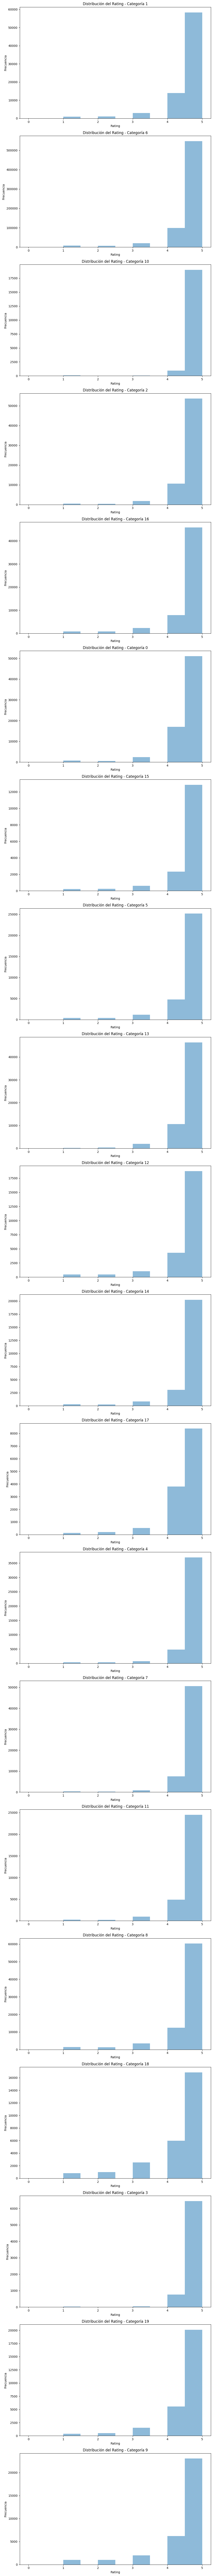

In [46]:
categorias_unicas = coursera['categoria'].unique()

# Configurar el diseño del gráfico
fig, axs = plt.subplots(len(categorias_unicas), figsize=(10, 6*len(categorias_unicas)), tight_layout=True)

# Generar los histogramas para cada categoría
for i, categoria in enumerate(categorias_unicas):
    group = coursera[coursera['categoria'] == categoria]['rating']
    axs[i].hist(group, bins=10, range=(0, 5), alpha=0.5)
    axs[i].set_title(f"Distribución del Rating - Categoría {categoria}")
    axs[i].set_xlabel("Rating")
    axs[i].set_ylabel("Frecuencia")

plt.show()

In [49]:
coursera.head()

name          institution         course_id rating  year  \
0  Machine Learning  Stanford University  machine-learning      1  2017   
1  Machine Learning  Stanford University  machine-learning      1  2015   
2  Machine Learning  Stanford University  machine-learning      1  2019   
3  Machine Learning  Stanford University  machine-learning      1  2015   
4  Machine Learning  Stanford University  machine-learning      1  2015   

   month  reviewers_count  categoria  
0      3            35895          1  
1     11            35895          1  
2      4            35895          1  
3      9            35895          1  
4     12            35895          1

In [50]:
#Guardo los cambios en el dataset de coursera

coursera.to_csv("Datasets/Coursera.csv", index=False)

Conclusiones:
* De acuerdo a la categorización realizada con los id de los cursos, no hay relación entre los mismos y el rating, dado que todos tienen mayor frecuencia de rating = 5. 
* La cantidad de reviews por cada id, es directamente proporcional a la cantidad de cursos dentro de cada categoría.
* En la mayoría de los cursos los títulos están conformados por: Introduction, Management, Programming, Fundamental, Machine Learning, Data, Design, Data Science, Python, business, Understanding, International, Excel
* Mientras que, teniendo en cuenta que el listado total de títulos tiene que ver con la cantidad de inscriptos que dejaron sus reviews, las palabras que más predominan son: Machine Learning, Data Science, Neural Networks, Python Programming, Getting Started, Deep Learning, Google CloudLearning Machine.
* La categoría 1 tiene la mayoría de cursos, los cuales se han agrupado de acuerdo a las siguientes palabras: Punctuation Grammar, Stanford Introduction, Machine Learning, Everyone AI, Digital World, Artificial Intelligence, Python Crash, HTML, CSS, Javascript. Por lo tanto esto indica los nombres o palabras que llamaron más la atención para que se inscribieran las personas
* El top 10 de cursos con el mejor rating difiere de la cantidad de inscriptos. No hay relación, por ende, entre el rating y el número de inscriptos. 

-----------------------------------------
### REVISIÓN DE LOS DATOS DE EDX

In [51]:
cursos_edx = pd.read_csv('Datasets/edx_courses.csv')

In [86]:
#Reviso el dataframe de edx para ver su estructura general

cursos_edx.head(1)

title                                            summary  \
0  How to Learn Online  Learn essential strategies for successful onli...   

   n_enrolled              course_type institution  \
0      124980  Self-paced on your time         edX   

                               instructors         Level  \
0  Nina Huntemann-Robyn Belair-Ben Piscopo  Introductory   

                        subject language subtitles       course_effort  \
0  Education & Teacher Training  English   English  2–3 hours per week   

  course_length                                        price  \
0       2 Weeks  FREE-Add a Verified Certificate for $49 USD   

                                  course_description  \
0  Designed for those who are new to elearning, t...   

                                     course_syllabus  certificate_price  \
0  Welcome - We start with opportunities to meet ...               49.0   

   horas_min  horas_max  week_course_length  
0          2          3                   2

In [53]:
#Elimino la columna course_url
cursos_edx = cursos_edx.drop('course_url',1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\3503897298.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cursos_edx = cursos_edx.drop('course_url',1)


In [54]:
#Obtengo información detallada del dataframe cursos_edx

cursos_edx.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               975 non-null    object
 1   summary             922 non-null    object
 2   n_enrolled          855 non-null    object
 3   course_type         975 non-null    object
 4   institution         975 non-null    object
 5   instructors         972 non-null    object
 6   Level               975 non-null    object
 7   subject             975 non-null    object
 8   language            975 non-null    object
 9   subtitles           972 non-null    object
 10  course_effort       975 non-null    object
 11  course_length       975 non-null    object
 12  price               975 non-null    object
 13  course_description  935 non-null    object
 14  course_syllabus     417 non-null    object
dtypes: object(15)
memory usage: 114.4+ KB


In [55]:
#Reviso la cantidad de valores infinitos de la columa n_enrolled

cantidad_nofinitos = cursos_edx['n_enrolled'].isna().sum()
print(cantidad_nofinitos)

120


In [56]:
cursos_edx['n_enrolled'] = cursos_edx['n_enrolled'].replace([float('inf'), float('-inf')], float('nan')) #Reemplazo los valores infinitos con NaN
cursos_edx['n_enrolled'] = cursos_edx['n_enrolled'].str.replace(',', '') #Elimino las comas de los valores
cursos_edx['n_enrolled'] = cursos_edx['n_enrolled'].astype(float) #convierto los valores al tipo de dato float

In [57]:
cursos_edx['n_enrolled'] = cursos_edx['n_enrolled'].fillna(0) #Reemplazo los valores faltantes (NaN) con el valor 0 una vez más. 
cursos_edx['n_enrolled'] = cursos_edx['n_enrolled'].astype(int, errors='ignore') #Convierto los valores al tipo de dato entero

In [58]:
#Reviso nuevamente si hay datos infinitos

cantidad_nofinitos = cursos_edx['n_enrolled'].isna().sum()
print(cantidad_nofinitos)

0


In [59]:
#Chequeo que se hayan transformado

cursos_edx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               975 non-null    object
 1   summary             922 non-null    object
 2   n_enrolled          975 non-null    int32 
 3   course_type         975 non-null    object
 4   institution         975 non-null    object
 5   instructors         972 non-null    object
 6   Level               975 non-null    object
 7   subject             975 non-null    object
 8   language            975 non-null    object
 9   subtitles           972 non-null    object
 10  course_effort       975 non-null    object
 11  course_length       975 non-null    object
 12  price               975 non-null    object
 13  course_description  935 non-null    object
 14  course_syllabus     417 non-null    object
dtypes: int32(1), object(14)
memory usage: 110.6+ KB


In [60]:
#Muestro los valores únicos de la columna price y cuento el total

unique_prices = cursos_edx['price'].unique()
total_unique_prices = len(unique_prices)

print("Valores únicos de la columna 'price':")
print(unique_prices)
print("Total de precios únicos:", total_unique_prices)


Valores únicos de la columna 'price':
['FREE-Add a Verified Certificate for $49 USD'
 'FREE-Add a Verified Certificate for $90 USD'
 'FREE-Add a Verified Certificate for $199 USD'
 'FREE-Add a Verified Certificate for $249 USD'
 'FREE-Add a Verified Certificate for $5 USD'
 'FREE-Add a Verified Certificate for $99 USD'
 'FREE-Add a Verified Certificate for $39 USD'
 'FREE-Add a Verified Certificate for $399 USD'
 'FREE-Add a Verified Certificate for $149 USD'
 'FREE-Add a Verified Certificate for $125 USD'
 'FREE-Add a Verified Certificate for $40 USD'
 'FREE-Add a Verified Certificate for $25 USD'
 'FREE-Add a Verified Certificate for $50 USD'
 'FREE-Add a Verified Certificate for $169 USD'
 'FREE-Add a Verified Certificate for $70 USD'
 'FREE-Add a Verified Certificate for $79 USD'
 'FREE-Add a Verified Certificate for $150 USD'
 'FREE-Add a Verified Certificate for $69 USD'
 'FREE-Add a Verified Certificate for $200 USD'
 'FREE-Add a Verified Certificate for $225 USD'
 'FREE-Add a V

In [61]:
#Obtengo los valores de los precios de los certificados verificados de cada precio único

#Defino una función para extraer el valor numérico de un texto
def extract_numeric_value(text):
    match = re.search(r'\$([\d.]+)', text)
    if match:
        return float(match.group(1))
    return None

#Aplico la función para extraer los valores numéricos de la columna 'price'
cursos_edx['certificate_price'] = cursos_edx['price'].apply(extract_numeric_value)

#Muestro los valores numéricos de la columna 'price'
unique_prices_numeric = cursos_edx['certificate_price'].unique()
total_unique_prices_numeric = len(unique_prices_numeric)

print("Valores numéricos de la columna 'price':")
print(unique_prices_numeric)
print("Total de precios únicos (numéricos):", total_unique_prices_numeric)

Valores numéricos de la columna 'price':
[ 49.    90.   199.   249.     5.    99.    39.   399.   149.   125.
  40.    25.    50.   169.    70.    79.   150.    69.   200.   225.
  75.   300.   139.   350.    19.   100.   450.   119.    60.   299.
  29.    65.    15.   214.    10.    49.99 129.    59.   299.7  179.
 250.   399.6  159.   375.   166.    49.9   30.  ]
Total de precios únicos (numéricos): 47


In [62]:
cursos_edx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               975 non-null    object 
 1   summary             922 non-null    object 
 2   n_enrolled          975 non-null    int32  
 3   course_type         975 non-null    object 
 4   institution         975 non-null    object 
 5   instructors         972 non-null    object 
 6   Level               975 non-null    object 
 7   subject             975 non-null    object 
 8   language            975 non-null    object 
 9   subtitles           972 non-null    object 
 10  course_effort       975 non-null    object 
 11  course_length       975 non-null    object 
 12  price               975 non-null    object 
 13  course_description  935 non-null    object 
 14  course_syllabus     417 non-null    object 
 15  certificate_price   975 non-null    float64
dtypes: float

ANÁLISIS MULTIVARIADO

In [63]:
#Cantidad de inscriptos por curso

enrolled_by_title = cursos_edx.groupby('title')['n_enrolled'].sum()

enrolled_by_title_sorted = enrolled_by_title.sort_values(ascending=False)

print(enrolled_by_title_sorted)


title
CS50's Introduction to Computer Science                                           2442271
IELTS Academic Test Preparation                                                   1103777
TOEFL® Test Preparation: The Insider’s Guide                                      1022489
CS50's Web Programming with Python and JavaScript                                  698950
Introduction to Linux                                                              642088
                                                                                   ...   
SQL aplicado en la  ciencia de datos                                                    0
Sales Enablement & Analytics                                                            0
El método de ciencia de datos                                                           0
El manejo de plagas, malezas y enfermedades en los Sistemas de Siembra Directa          0
Scripting and Programming Foundations                                                   0
Name

La cantidad de cursos con n_enrolled igual a 0 es: 120


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


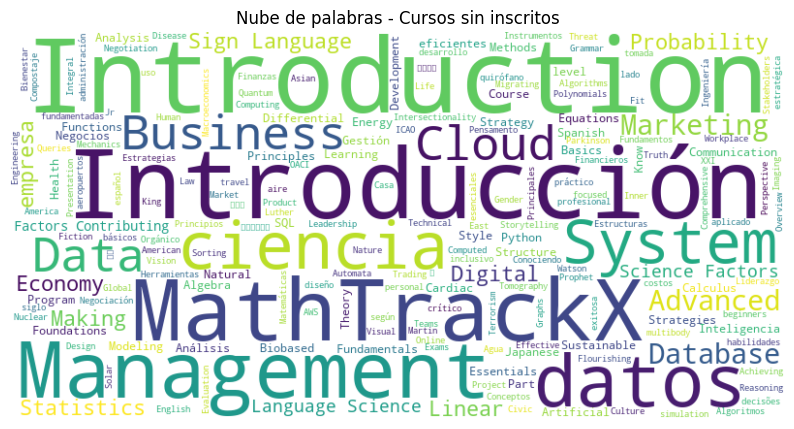

In [64]:
#Hay cursos que no tienen enrolados, los cuento

cantidad_cursos_sin_enrolled = (cursos_edx['n_enrolled'] == 0).sum()
print("La cantidad de cursos con n_enrolled igual a 0 es:", cantidad_cursos_sin_enrolled)

#Por lo tanto esos son cursos en los que puede que los clientes no se quieran inscribir. Armo una nube de palabras de los mismos
# Descargar las stopwords si aún no están descargadas
nltk.download('stopwords')
nltk.download('punkt')

# Filtrar los cursos sin inscritos
cursos_sin_enrolled = cursos_edx[cursos_edx['n_enrolled'] == 0]

# Concatenar los títulos de los cursos sin inscritos
text = ' '.join(cursos_sin_enrolled['title'].astype(str))

# Tokenizar el texto en palabras
tokens = word_tokenize(text)

# Eliminar palabras con menos de 2 caracteres y stopwords
stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('spanish'))
filtered_words = [word for word in tokens if len(word) > 2 and word.lower() not in stop_words]

# Unir las palabras filtradas en una cadena de texto
filtered_text = ' '.join(filtered_words)

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Cursos sin inscritos')
plt.show()



Son palabras que aparecen en los cursos que tienen buen rating en Coursera. Por lo tanto continúo analizando otras relaciones que indiquen motivos por lo que no tuvieron inscriptos en estos cursos. 

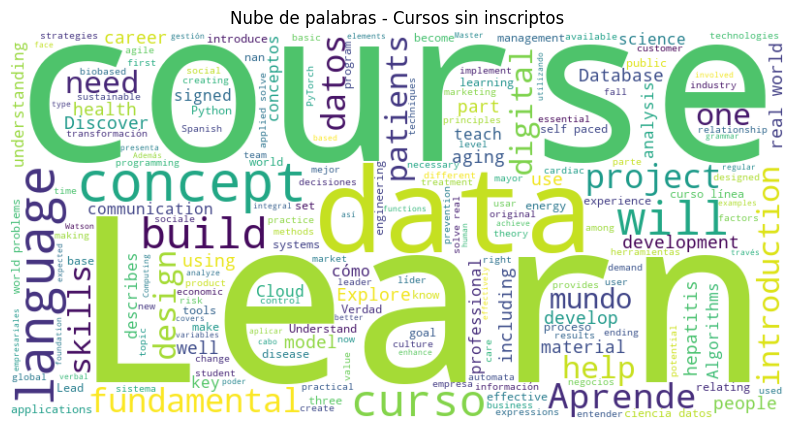

In [65]:
#Reviso si el summary de los cursos que no tienen inscriptos influye en que no los elijan. Recurro al Word Cloud

# Filtrar los cursos sin inscritos
cursos_sin_enrolled = cursos_edx[cursos_edx['n_enrolled'] == 0]

# Concatenar los títulos de los cursos sin inscriptos
text = ' '.join(cursos_sin_enrolled['summary'].astype(str))

# Tokenizar el texto en palabras
tokens = word_tokenize(text)

# Eliminar palabras con menos de 2 caracteres y stopwords
stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('spanish'))
filtered_words = [word for word in tokens if len(word) > 2 and word.lower() not in stop_words]

# Unir las palabras filtradas en una cadena de texto
filtered_text = ' '.join(filtered_words)

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Cursos sin inscriptos')
plt.show()

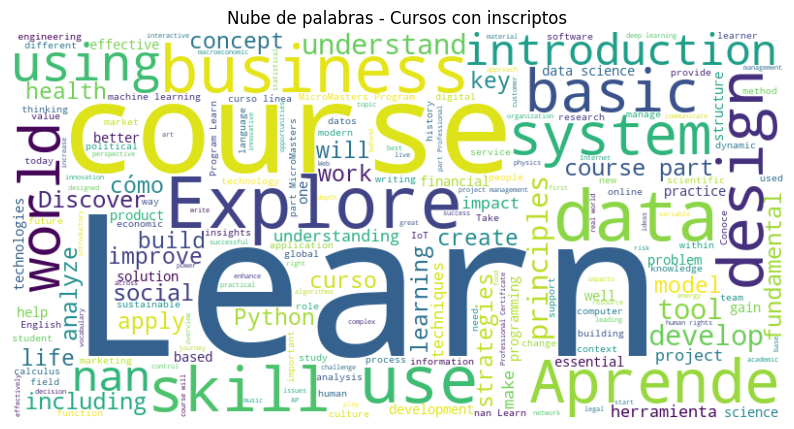

In [66]:
#Reviso si el summary de los cursos que tienen inscriptos influye en que los elijan. Recurro al Word Cloud

# Filtrar los cursos con inscritos
cursos_con_enrolled = cursos_edx[cursos_edx['n_enrolled'] != 0]

# Concatenar los títulos de los cursos sin inscriptos
text = ' '.join(cursos_con_enrolled['summary'].astype(str))

# Tokenizar el texto en palabras
tokens = word_tokenize(text)

# Eliminar palabras con menos de 2 caracteres y stopwords
stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('spanish'))
filtered_words = [word for word in tokens if len(word) > 2 and word.lower() not in stop_words]

# Unir las palabras filtradas en una cadena de texto
filtered_text = ' '.join(filtered_words)

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Cursos con inscriptos')
plt.show()

In [67]:
#Reviso si la longitud de las descripciones influye en los inscriptos

titulos_unicos = cursos_edx['title'].unique()

#Creo un nuevo dataframe para el análisis
df_analysis = pd.DataFrame({'title': titulos_unicos})

df_analysis['summary_length'] = df_analysis['title'].map(cursos_edx.groupby('title')['summary'].first().str.len())

df_sorted = df_analysis.sort_values('summary_length', ascending=False)
#print(df_sorted[['title', 'summary_length']])

df_sorted_top_10 = df_sorted.head(10)
print(df_sorted_top_10[['title', 'summary_length']])

                                                 title  summary_length
772  What Every Provider Should Know: Clinical Fund...           783.0
155           Japanese Books: From Manuscript to Print           736.0
460    Agua 2.0: empresas eficientes para el siglo XXI           668.0
879                                   Know HBV And HCV           646.0
918     The Business of Aging in the Longevity Economy           549.0
554                    Foundations of Central Bank Law           527.0
893                     Comisión de la Verdad Colombia           526.0
364       Work and Employment for a Sustainable Future           494.0
175                 Success: Practical Thinking Skills           491.0
408           COVID-19 Training for Healthcare Workers           480.0


In [68]:
df_analysis['n_enrolled'] = df_analysis['title'].map(cursos_edx.groupby('title')['n_enrolled'].first())

correlation = df_analysis['summary_length'].corr(df_analysis['n_enrolled'])
print("Correlación entre longitud de descripciones y cantidad de inscritos:", correlation)


Correlación entre longitud de descripciones y cantidad de inscritos: -0.1137728128604299


No hay correlación entre la longitud de las descripciones y la cantidad de inscriptos

In [69]:
df_sorted_bottom_10 = df_sorted.tail(10).sort_values('summary_length')
print(df_sorted_bottom_10[['title', 'summary_length']])

                                                 title  summary_length
797  Modern Japanese Architecture Part 1: From Meij...             NaN
799  A-level Mathematics for Year 12 - Course 2: Ca...             NaN
805  Radio para internet con Podcast: creación y co...             NaN
836  Soy docente, ¡qué miedo! Gestiona eficazmente ...             NaN
851                              La España del Quijote             NaN
864  Idealismo filosófico y cosmovisiones: cómo hac...             NaN
885       Introducción al Derecho en la vida cotidiana             NaN
895  Health Informatics for better and safer health...             NaN
902                       Understanding Nuclear Energy             NaN
907                      Entrepreneurial Opportunities             NaN


In [70]:
#Identifico que hay algunos 'summary' que no tienen datos. Reviso si coinciden con los cursos que no tienen inscriptos

cursos_sin_summary = cursos_edx[cursos_edx['summary'].isnull()]
cantidad_cursos_sin_summary = len(cursos_sin_summary)
print("Cantidad de cursos sin 'summary':", cantidad_cursos_sin_summary)
cursos_sin_summary_sin_inscritos = cursos_sin_summary[cursos_sin_summary['n_enrolled'] == 0]
cantidad_cursos_sin_summary_sin_inscritos = len(cursos_sin_summary_sin_inscritos)
porcentaje_cursos_sin_summary_sin_inscritos = (cantidad_cursos_sin_summary_sin_inscritos / len(cursos_sin_summary)) * 100
print("Cantidad de cursos sin 'summary' y sin inscritos:", cantidad_cursos_sin_summary_sin_inscritos)
print("Porcentaje de cursos sin 'summary' y sin inscritos:", porcentaje_cursos_sin_summary_sin_inscritos, "%")


Cantidad de cursos sin 'summary': 53
Cantidad de cursos sin 'summary' y sin inscritos: 4
Porcentaje de cursos sin 'summary' y sin inscritos: 7.547169811320755 %


No es relevante que no tengan summary los cursos

In [71]:
#Selecciono las columnas numéricas para el cálculo de la matriz de correlación, es decir, cantidad de enrolados y precios de los certificados
columnas_numericas = ['n_enrolled', 'certificate_price']

#Filtro el DataFrame con las columnas numéricas seleccionadas
df_numericas = cursos_edx[columnas_numericas]

#Calculo la matriz de correlación
matriz_correlacion = df_numericas.corr()
print(matriz_correlacion)

                   n_enrolled  certificate_price
n_enrolled           1.000000           0.051278
certificate_price    0.051278           1.000000


La cantidad de enrolados tiene una correlación muy débil con el precio de los certificados, no es significativa

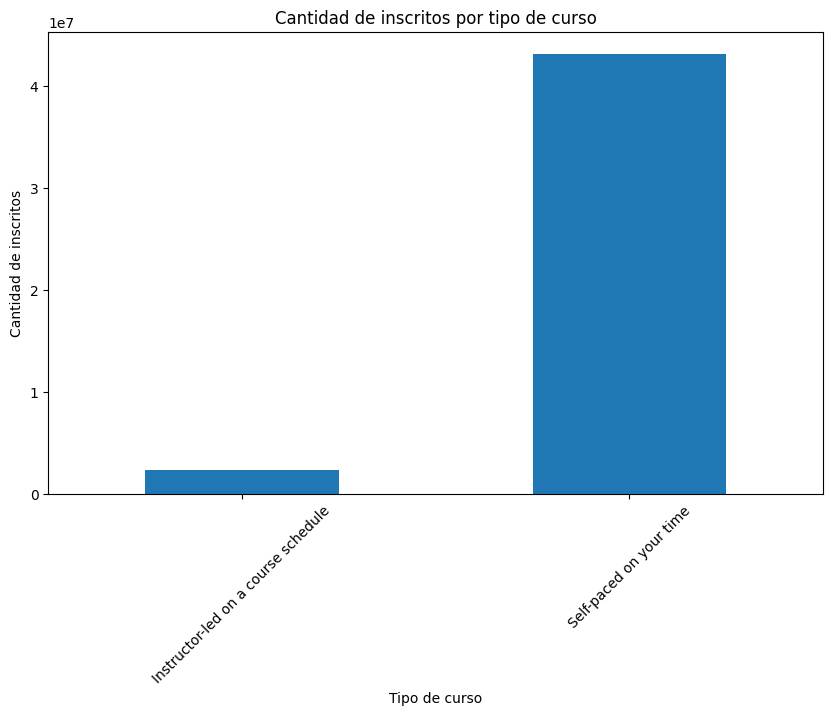

In [72]:
#Determinar si la cantidad de enrolados tiene relación con el tipo de curso

enrolled_by_course_type = cursos_edx.groupby('course_type')['n_enrolled'].sum()
plt.figure(figsize=(10, 6))
enrolled_by_course_type.plot(kind='bar')
plt.xlabel('Tipo de curso')
plt.ylabel('Cantidad de inscritos')
plt.title('Cantidad de inscritos por tipo de curso')
plt.xticks(rotation=45)
plt.show()


In [73]:
total_inscritos = cursos_edx.groupby('course_type')['n_enrolled'].sum()
inscritos_tipo_A = total_inscritos['Self-paced on your time']
inscritos_tipo_B = total_inscritos['Instructor-led on a course schedule']
porcentaje_A = (inscritos_tipo_A / total_inscritos.sum()) * 100
porcentaje_B = (inscritos_tipo_B / total_inscritos.sum()) * 100
print("Porcentaje de inscritos en Tipo A:", porcentaje_A,'%')
print("Porcentaje de inscritos en Tipo B:", porcentaje_B,'%')


Porcentaje de inscritos en Tipo A: 94.7938143424335 %
Porcentaje de inscritos en Tipo B: 5.206185657566494 %


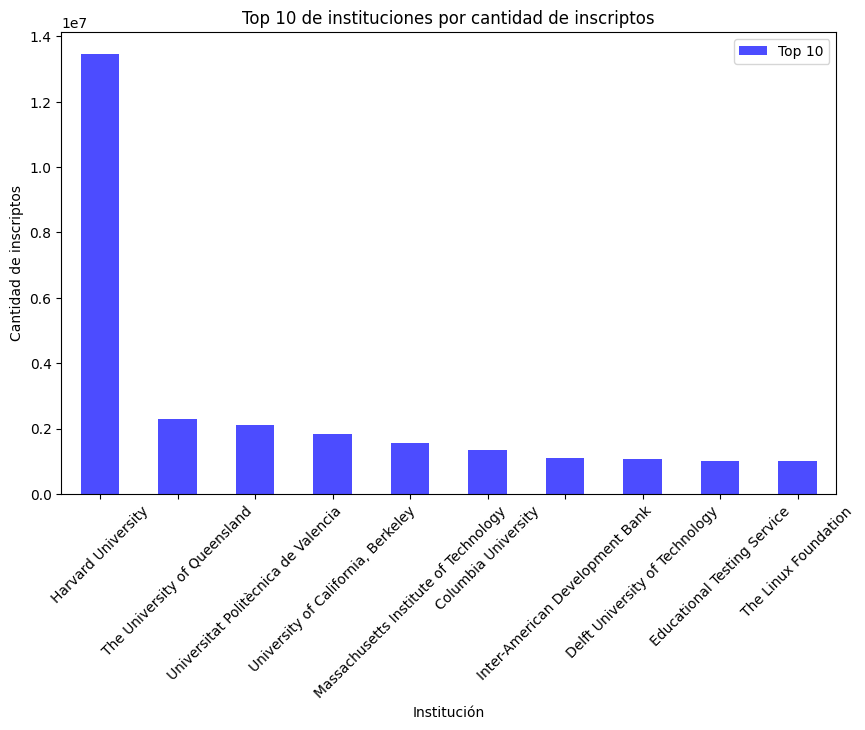

In [74]:
enrolled_by_institution = cursos_edx.groupby('institution')['n_enrolled'].sum()
enrolled_by_institution_sorted = enrolled_by_institution.sort_values(ascending=False)
top_10_institutions = enrolled_by_institution_sorted.head(10)

plt.figure(figsize=(10, 6))
top_10_institutions.plot(kind='bar', color='blue', alpha=0.7, label='Top 10')
plt.xlabel('Institución')
plt.ylabel('Cantidad de inscriptos')
plt.title('Top 10 de instituciones por cantidad de inscriptos')
plt.legend()
plt.xticks(rotation=45)
plt.show()



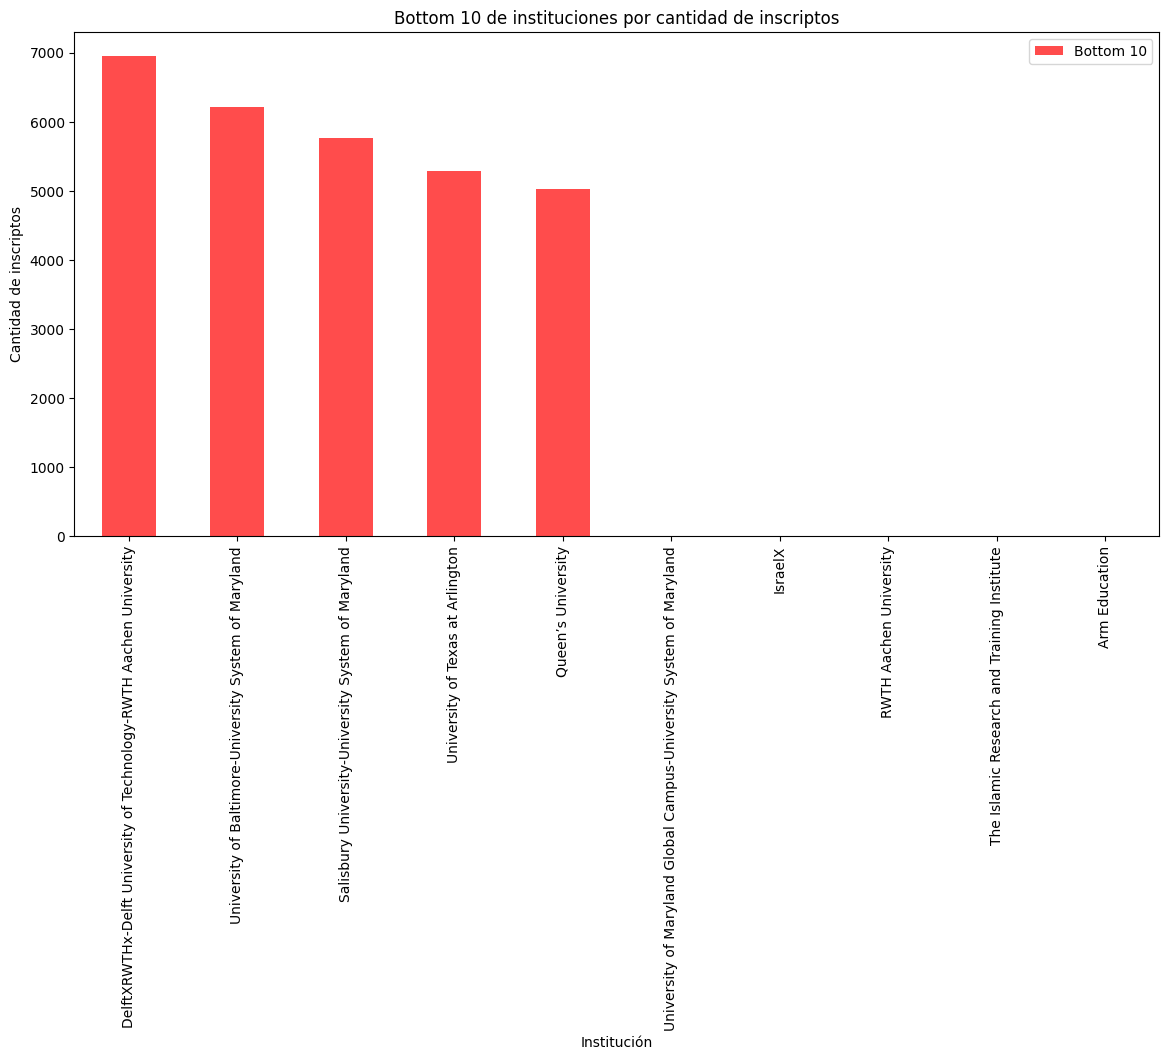

In [75]:
enrolled_by_institution = cursos_edx.groupby('institution')['n_enrolled'].sum()
enrolled_by_institution_sorted = enrolled_by_institution.sort_values(ascending=False)
bottom_10_institutions = enrolled_by_institution_sorted.tail(10)

plt.figure(figsize=(14, 8))
bottom_10_institutions.plot(kind='bar', color='red', alpha=0.7, label='Bottom 10')
plt.xlabel('Institución')
plt.ylabel('Cantidad de inscriptos')
plt.title('Bottom 10 de instituciones por cantidad de inscriptos')
plt.legend()
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation='vertical')
plt.show()

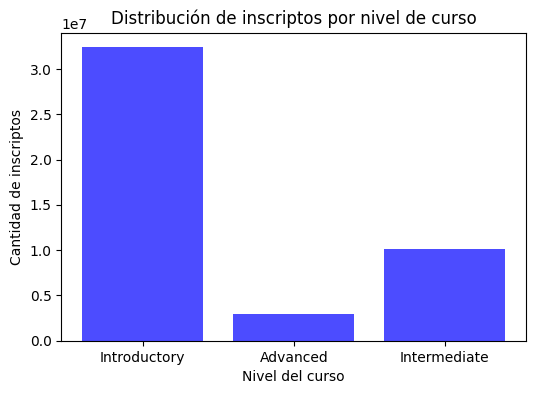

In [149]:
#Evalúo la cantidad de inscriptos por niveles de los cursos
introductory_enrolled = cursos_edx[cursos_edx['Level'] == 'Introductory']['n_enrolled'].sum()
advanced_enrolled = cursos_edx[cursos_edx['Level'] == 'Advanced']['n_enrolled'].sum()
intermediate_enrolled = cursos_edx[cursos_edx['Level'] == 'Intermediate']['n_enrolled'].sum()

niveles = ['Introductory', 'Advanced', 'Intermediate']
inscritos = [introductory_enrolled, advanced_enrolled, intermediate_enrolled]

plt.figure(figsize=(6, 4))
plt.bar(niveles, inscritos, color='blue', alpha=0.7)
plt.xlabel('Nivel del curso')
plt.ylabel('Cantidad de inscriptos')
plt.title('Distribución de inscriptos por nivel de curso')
plt.show()


La mayor parte de inscriptos se orienta a cursos de nivel introductorio

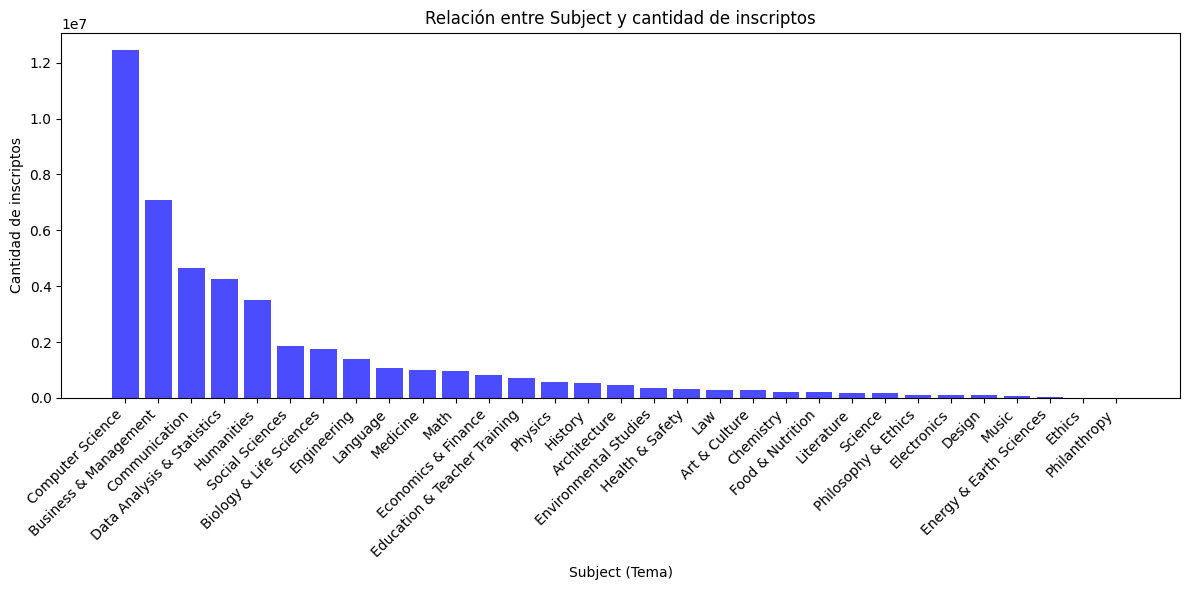

In [76]:
enrolled_by_subject = cursos_edx.groupby('subject')['n_enrolled'].sum()
enrolled_by_subject_sorted = enrolled_by_subject.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(enrolled_by_subject_sorted)), enrolled_by_subject_sorted, color='blue', alpha=0.7)
plt.xlabel('Subject (Tema)')
plt.ylabel('Cantidad de inscriptos')
plt.title('Relación entre Subject y cantidad de inscriptos')
plt.xticks(range(len(enrolled_by_subject_sorted)), enrolled_by_subject_sorted.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()



C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\54751946.py:13: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\54751946.py:13: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  plt.tight_layout()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\54751946.py:13: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from current font.
  plt.tight_layout()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\54751946.py:13: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  plt.tight_layout()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\54751946.py:13: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  plt.tight_layout()
C:\Users\Usuario\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK U

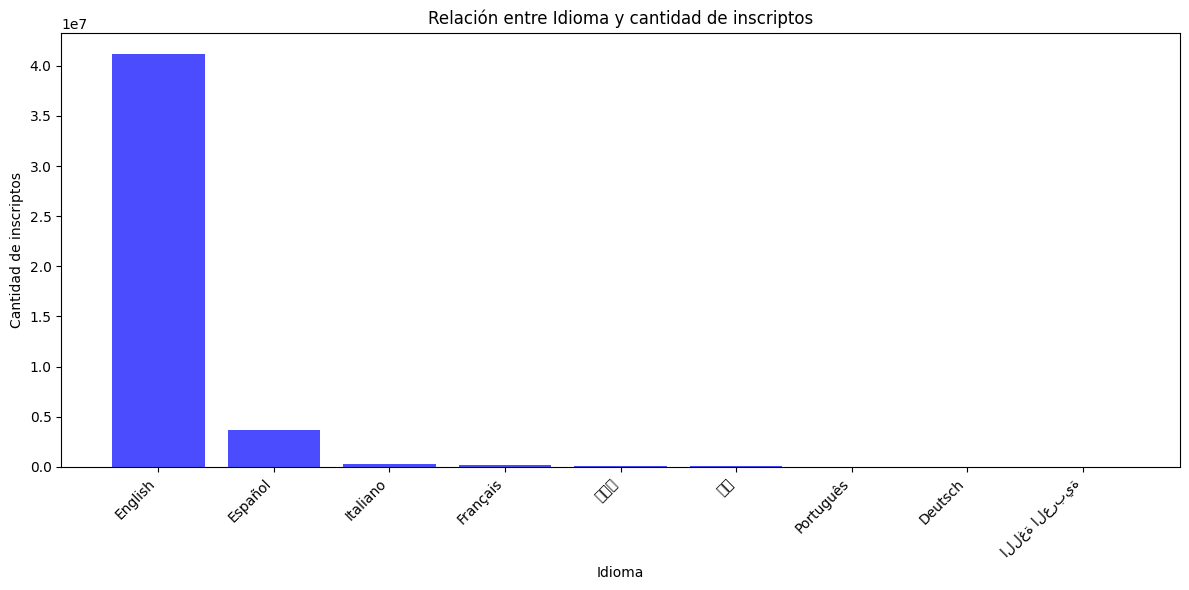

In [77]:
enrolled_by_language = cursos_edx.groupby('language')['n_enrolled'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(len(enrolled_by_language)), enrolled_by_language, color='blue', alpha=0.7)
plt.xlabel('Idioma')
plt.ylabel('Cantidad de inscriptos')
plt.title('Relación entre Idioma y cantidad de inscriptos')

# Ajustar las etiquetas del eje x
plt.xticks(range(len(enrolled_by_language)), enrolled_by_language.index, rotation=45, ha='right')

# Ajustar el espaciado entre las etiquetas del eje x
plt.tight_layout()

plt.show()


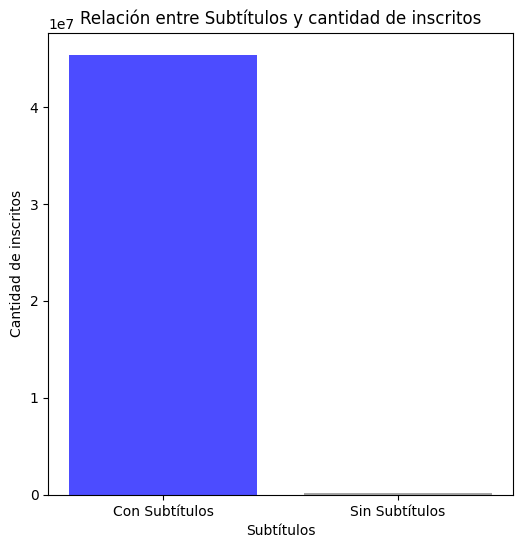

In [78]:
# Contar la cantidad de cursos con y sin subtítulos
count_with_subtitles = cursos_edx[cursos_edx['subtitles'].notnull()]['n_enrolled'].sum()
count_without_subtitles = cursos_edx[cursos_edx['subtitles'].isnull()]['n_enrolled'].sum()

# Crear un DataFrame con los datos
data = {'Con Subtítulos': count_with_subtitles, 'Sin Subtítulos': count_without_subtitles}
df = pd.DataFrame.from_dict(data, orient='index', columns=['Cantidad de inscritos'])

# Generar el gráfico de barras
plt.figure(figsize=(6, 6))
plt.bar(df.index, df['Cantidad de inscritos'], color=['blue', 'gray'], alpha=0.7)
plt.xlabel('Subtítulos')
plt.ylabel('Cantidad de inscritos')
plt.title('Relación entre Subtítulos y cantidad de inscritos')

plt.show()


C:\Users\Usuario\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Usuario\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Usuario\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Usuario\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Usuario\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2367 (\N{DEVA

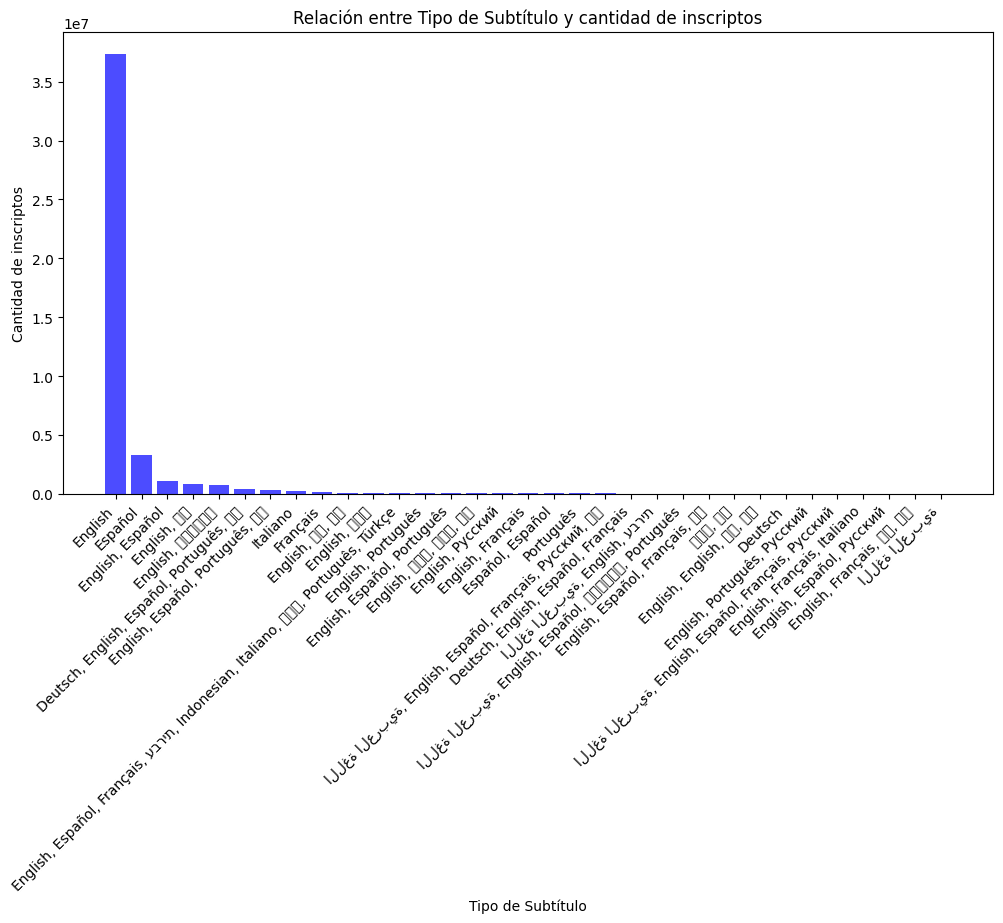

In [79]:
# Contar la cantidad de inscritos por tipo de subtítulo
enrolled_by_subtitle_type = cursos_edx.groupby('subtitles')['n_enrolled'].sum()


# Ordenar los datos de mayor a menor cantidad de inscritos
enrolled_by_subtitle_type = enrolled_by_subtitle_type.sort_values(ascending=False)

# Generar el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(enrolled_by_subtitle_type.index, enrolled_by_subtitle_type, color='blue', alpha=0.7)
plt.xlabel('Tipo de Subtítulo')
plt.ylabel('Cantidad de inscriptos')
plt.title('Relación entre Tipo de Subtítulo y cantidad de inscriptos')

# Ajustar las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

plt.show()


In [80]:
# Crear una tabla de contingencia entre el lenguaje original y los subtítulos
contingency_table = pd.crosstab(cursos_edx['language'], cursos_edx['subtitles'])

# Realizar el análisis de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Imprimir los resultados
print("Tabla de contingencia:")
print(contingency_table)
print("\n")
print("Resultados del análisis de chi-cuadrado:")
print("Estadístico chi-cuadrado:", chi2)
print("Valor p:", p)
print("Grados de libertad:", dof)


Tabla de contingencia:
subtitles      Deutsch  Deutsch, English, Español, Français  \
language                                                      
Deutsch              1                                    0   
English              0                                    1   
Español              0                                    0   
Français             0                                    0   
Italiano             0                                    0   
Português            0                                    0   
اللغة العربية        0                                    0   
中文                   0                                    0   
日本語                  0                                    0   

subtitles      Deutsch, English, Español, Português, 中文  English  \
language                                                           
Deutsch                                               0        0   
English                                               1      708   
Español    

In [81]:
#Extraigo horas mínimas y horas máximas de esfuerzo semanal

#Creo las columnas nuevas nuevas
cursos_edx['horas_min'] = cursos_edx['course_effort'].apply(lambda x: re.findall(r'\d+', x)[0] if isinstance(x, str) and re.findall(r'\d+', x) else None)
cursos_edx['horas_max'] = cursos_edx['course_effort'].apply(lambda x: re.findall(r'\d+', x)[1] if isinstance(x, str) and len(re.findall(r'\d+', x)) > 1 else None)

#Las convierto a int
cursos_edx['horas_min'] = pd.to_numeric(cursos_edx['horas_min'], errors='coerce')
cursos_edx['horas_max'] = pd.to_numeric(cursos_edx['horas_max'], errors='coerce')

print(cursos_edx[['course_effort', 'horas_min', 'horas_max']])

            course_effort  horas_min  horas_max
0      2–3 hours per week          2          3
1      2–4 hours per week          2          4
2     6–18 hours per week          6         18
3    10–15 hours per week         10         15
4      5–7 hours per week          5          7
..                    ...        ...        ...
970    4–5 hours per week          4          5
971    3–5 hours per week          3          5
972    4–6 hours per week          4          6
973    1–2 hours per week          1          2
974    3–6 hours per week          3          6

[975 rows x 3 columns]


In [82]:
#Analizo si hay relación entre las horas mínimas, máximas y la cantidad de inscriptos

data = cursos_edx[['horas_min', 'horas_max', 'n_enrolled']]

#Elimino filas con valores NaN
data = data.dropna()

#Calculo la matriz de correlación
correlation_matrix = data[['horas_min', 'horas_max', 'n_enrolled']].corr()
correlation = correlation_matrix.loc['horas_min', 'n_enrolled']
print("Coeficiente de correlación entre horas mínimas y cantidad de inscriptos:", correlation)

correlation = correlation_matrix.loc['horas_max', 'n_enrolled']
print("Coeficiente de correlación entre horas máximas y cantidad de inscriptos:", correlation)

Coeficiente de correlación entre horas mínimas y cantidad de inscriptos: 0.022015092961584805
Coeficiente de correlación entre horas máximas y cantidad de inscriptos: 0.09863093291244893


In [83]:
#Extraigo de 'course_lenght' sólo los valores numéricos y los coloco en una columna nueva 'week_course_lenght'

def extract_numbers(text):
    numbers = re.findall(r'\d+', text)
    if numbers:
        return int(numbers[0])
    else:
        return None

#Aplico la función a la columna 'course_length' y creo la nueva columna 'week_course_length'
cursos_edx['week_course_length'] = cursos_edx['course_length'].apply(extract_numbers)

print(cursos_edx[['course_length', 'week_course_length']])

    course_length  week_course_length
0         2 Weeks                   2
1         7 Weeks                   7
2        12 Weeks                  12
3        13 Weeks                  13
4         4 Weeks                   4
..            ...                 ...
970      10 Weeks                  10
971      12 Weeks                  12
972       6 Weeks                   6
973       1 Weeks                   1
974       4 Weeks                   4

[975 rows x 2 columns]


In [84]:
#Calculo el coeficiente de correlación entre la duración del curso y la cantidad de inscriptos
correlation = np.corrcoef(cursos_edx['week_course_length'], cursos_edx['n_enrolled'])[0, 1]
print("Coeficiente de correlación entre week_course_length y n_enrolled:", correlation)

Coeficiente de correlación entre week_course_length y n_enrolled: 0.1661446419977448


Conclusiones:
* No se tiene información acerca de si hubo inscriptos que pagaran la certificación verificada de los cursos que las poseen. Por ende no puede inferirse nada al respecto para el KPI solicitado en las consignas
* A partir de las Word Clouds de 'summary' de los cursos con inscriptos vs los cursos sin inscriptos, se obtiene que las palabras que tienen los cursos de la segunda categoría y no la primera son: 'concept', 'language', 'project', 'build' y en cambio la primera tiene: 'Explore', 'business', 'use', 'design', 'world', 'basic', 'system', 'using', 'skill'
* No hay correlación entre la longitud de las descripciones y la cantidad de inscriptos
* Que los cursos tengan inscriptos o no, no depende si el curso tiene descripción o no.
* La cantidad de enrolados tiene una correlación muy débil con el precio de los certificados, no es significativa
* El 95% de inscriptos se anotó en cursos Self-paced
* La Universidad de Harvard se lleva la mayor cantidad de inscriptos, al igual que en Coursera, la mayor cantidad de inscriptos no está sólo en cursos que dictan universidades.
* Los temas con mayoría de inscriptos son: Computer Science, Business & Management, Communication, Data Analytics & Statistics, Humanities, Biology & Life Sciences, Engineering, Language, Medicine
* El idioma predominante, tanto en el lenguaje original cómo en los subtítulos, a la hora de inscribirse es el Inglés, seguido del Español.
* A partir del análisis de chi-cuadrado, se infiere que existe una asociación significativa entre el lenguaje original, los subtítulos y la cantidad de inscriptos en los cursos.
* Además resulta de amplia diferencia si los cursos tienen subtítulos
* Aunque existe una correlación positiva débil entre las horas mínimas y máximas semanales con la cantidad de inscriptos, no parece ser un factor determinante en la cantidad de personas que se inscriben en los cursos
* El coeficiente de correlación entre la duración de los cursos y la cantidad de inscriptos es débil.   


In [85]:
cursos_edx.to_csv('Datasets/edx.csv', index=False)

-----------------------------------------
### REVISIÓN DE LOS DATOS DE UDEMY

In [2]:
cursos_udemy = pd.read_csv('Datasets/udemy_courses.csv')

In [3]:
#Reviso el dataframe de edx para ver su estructura general

cursos_udemy.head(1)

course_id                        course_title  \
0    1070968  Ultimate Investment Banking Course   

                                                 url  is_paid  price  \
0  https://www.udemy.com/ultimate-investment-bank...     True    200   

   num_subscribers  num_reviews  num_lectures       level  content_duration  \
0             2147           23            51  All Levels               1.5   

    published_timestamp           subject  
0  2017-01-18T20:58:58Z  Business Finance

In [4]:
#Elimino la columna url
cursos_udemy = cursos_udemy.drop('url',1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\5091595.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cursos_udemy = cursos_udemy.drop('url',1)


In [5]:
#Obtengo información detallada del dataframe cursos_udemy

cursos_udemy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3678 non-null   int64  
 1   course_title         3678 non-null   object 
 2   is_paid              3678 non-null   bool   
 3   price                3678 non-null   int64  
 4   num_subscribers      3678 non-null   int64  
 5   num_reviews          3678 non-null   int64  
 6   num_lectures         3678 non-null   int64  
 7   level                3678 non-null   object 
 8   content_duration     3678 non-null   float64
 9   published_timestamp  3678 non-null   object 
 10  subject              3678 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(4)
memory usage: 291.1+ KB


In [6]:
#Separo la columna published_timestamp en year y month

cursos_udemy[['year', 'month']] = cursos_udemy['published_timestamp'].str.extract('(\d{4})-(\d{2})')

cursos_udemy['year'] = cursos_udemy['year'].astype(int)
cursos_udemy['month'] = cursos_udemy['month'].astype(int)



In [7]:
#Elimino la columna published_timestamp

cursos_udemy = cursos_udemy.drop('published_timestamp',1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11804\1044302616.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cursos_udemy = cursos_udemy.drop('published_timestamp',1)


ANÁLISIS UNIVARIADO

In [87]:
cursos_udemy.describe()

course_id        price  num_subscribers   num_reviews  num_lectures  \
count  3.678000e+03  3678.000000      3678.000000   3678.000000   3678.000000   
mean   6.759720e+05    66.049483      3197.150625    156.259108     40.108755   
std    3.432732e+05    61.005755      9504.117010    935.452044     50.383346   
min    8.324000e+03     0.000000         0.000000      0.000000      0.000000   
25%    4.076925e+05    20.000000       111.000000      4.000000     15.000000   
50%    6.879170e+05    45.000000       911.500000     18.000000     25.000000   
75%    9.613555e+05    95.000000      2546.000000     67.000000     45.750000   
max    1.282064e+06   200.000000    268923.000000  27445.000000    779.000000   

       content_duration         year        month  
count       3678.000000  3678.000000  3678.000000  
mean           4.094517  2015.431213     6.164220  
std            6.053840     1.185317     3.380535  
min            0.000000  2011.000000     1.000000  
25%            1.000000  2015.000000     3.000000  
50%            2.000000  2016.000000     6.000000  
75%            4.500000  2016.000000     9.000000  
max           78.500000  2017.000000    12.000000

Conclusiones de la tabla:
* El precio mínimo es 0, por lo tanto deben haber espacios con valores nulos o cursos con precio = $0
* El precio promedio es de $66,05
* Un 75% de los cursos tiene un precio >= $95
* El mínimo de número de suscriptores es 0, de lo que se obtiene que pueden haber literalmente cursos sin inscriptos o valores atípicos o incorrectos
* El promedio de suscriptores por curso es de aproximadamente 3.197
* El máximo de suscriptores es 268.923
* El 75% de los cursos tiene 2.546 suscriptores o menos
* El promedio de reseñas por curso es aproximadamente 156,26
* El mínimo de reseñas es 0, puede coincidir con los 0 inscriptos
* Mientras que el máximo es 27.445
* Un 75% de cursos tienen 67 reseñas o menos
* El promedio de clases por curso está alrededor de 40,11
* El mínimo de clases es 0, aquí se puede tratar de valores nulos o incorrectos
* El máximo de clases es 779
* El promedio de duración de los cursos es aproximadamente 4,09 horas
* El mínimo de duración de los cursos es de 0 hs, al igual que con el mínimo de clases, pueden ser valores nulos o incorrectos
* El máximo de duración de los cursos es de 78,5 hs
* Hay un 75% de cursos que tienen una duración de 4,5 horas
* El registro de cursos va del año 2015 al 2017

In [10]:
#Reviso las conclusiones obtenidas a partir de la tabla anterior

#Valores nulos en la columna price
nulos = cursos_udemy['price'].isnull().sum()
print('Hay ',nulos, 'precios nulos')

#Valores nulos en la columna num_subscribers
nulos1 = cursos_udemy['num_subscribers'].isnull().sum()
print('Hay ',nulos1, 'suscriptores nulos')

#Valores nulos en la columna num_reviews
nulos2 = cursos_udemy['num_reviews'].isnull().sum()
print('Hay ',nulos2, 'reseñas nulas')

#Valores nulos en la columna num_lectures
nulos3 = cursos_udemy['num_lectures'].isnull().sum()
print('Hay ',nulos3, 'clases nulas')

#Valores nulos en la columna content_duration
nulos3 = cursos_udemy['content_duration'].isnull().sum()
print('Hay ',nulos3, 'nulos en duración del contenido')

Hay  0 precios nulos
Hay  0 suscriptores nulos
Hay  0 reseñas nulas
Hay  0 clases nulas
Hay  0 nulos en duración del contenido


* No hay precios nulos, sólo columnas con precios = $0
* No hay valores nulos en la columna de cantidad de suscriptores, sólo columnas con 0 suscriptores (es decir, cantidad de personas que se han inscrito o comprado un curso), que son la mayoría
* En cuanto a clases nulas, los valores = 0 pueden ser errores de tipeo, pero no son nulos. Lo mismo ocurre con la duración.

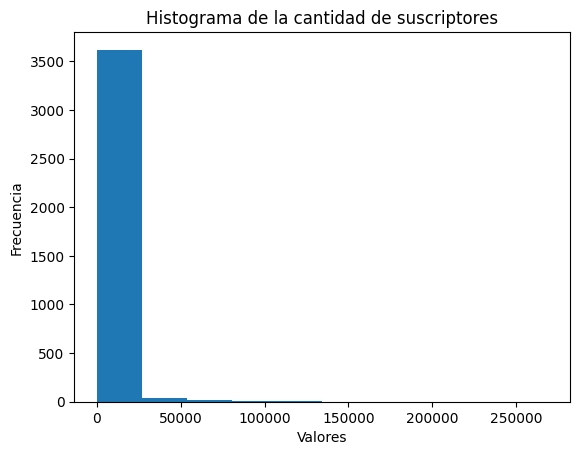

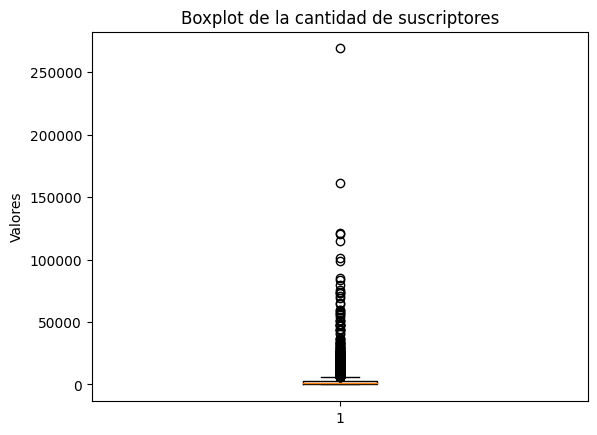

In [11]:
#Realizo un histograma para revisar los valores de los suscriptores
plt.hist(cursos_udemy['num_subscribers'], bins=10) 
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de la cantidad de suscriptores')
plt.show()

#Realizo un boxplot
plt.boxplot(cursos_udemy['num_subscribers'])
plt.ylabel('Valores')
plt.title('Boxplot de la cantidad de suscriptores')
plt.show()

In [11]:
#Reviso cuál es el curso más popular

curso_mas_popular = cursos_udemy.loc[cursos_udemy['num_subscribers'].idxmax()]
print(curso_mas_popular)

course_id                                             41295
course_title           Learn HTML5 Programming From Scratch
is_paid                                               False
price                                                     0
num_subscribers                                      268923
num_reviews                                            8629
num_lectures                                             45
level                                            All Levels
content_duration                                       10.5
published_timestamp                    2013-02-14T07:03:41Z
subject                                     Web Development
year                                                   2013
month                                                     2
Name: 2827, dtype: object


In [12]:
#Reviso la cantidad de cursos pagos y gratuitos

cursos_gratuitos = cursos_udemy.loc[cursos_udemy['is_paid'] == False]
cursos_de_pago = cursos_udemy.loc[cursos_udemy['is_paid'] == True]

total_cursos_gratuitos = cursos_gratuitos.shape[0]
total_cursos_de_pago = cursos_de_pago.shape[0]

print('La cantidad de cursos gratuitos es: ', total_cursos_gratuitos)
print('La cantidad de cursos pagos es: ', total_cursos_de_pago)

La cantidad de cursos gratuitos es:  310
La cantidad de cursos pagos es:  3368


2011       5
2012      45
2013     202
2014     491
2015    1014
2016    1206
2017     715
Name: year, dtype: int64


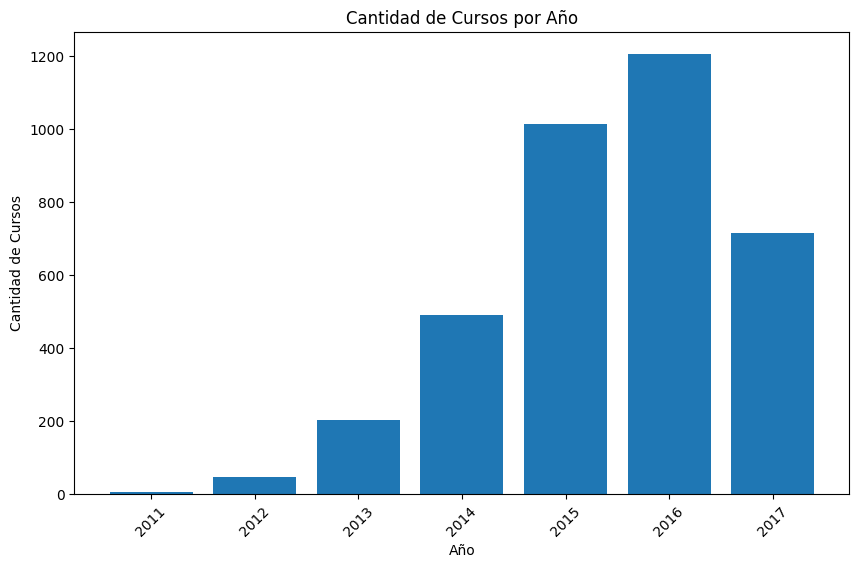

In [13]:
cursos_por_anio = cursos_udemy['year'].value_counts().sort_index()
print(cursos_por_anio)

plt.figure(figsize=(10, 6))
plt.bar(cursos_por_anio.index, cursos_por_anio.values)
plt.xlabel('Año')
plt.ylabel('Cantidad de Cursos')
plt.title('Cantidad de Cursos por Año')
plt.xticks(rotation=45)
plt.show()


ANÁLISIS MULTIVARIADO

In [14]:
#Cuales son los 10 cursos más populares

cursos_populares = cursos_udemy.nlargest(11, 'num_subscribers')
print(cursos_populares)

      course_id                                       course_title  is_paid  \
2827      41295               Learn HTML5 Programming From Scratch    False   
3032      59014                     Coding for Entrepreneurs Basic    False   
3230     625204                         The Web Developer Bootcamp     True   
2783     173548  Build Your First Website in 1 Week with HTML5 ...    False   
3232     764164              The Complete Web Developer Course 2.0     True   
1896      19421              Free Beginner Electric Guitar Lessons    False   
2589     473160  Web Design for Web Developers: Build Beautiful...    False   
2619      94430             Learn Javascript & JQuery From Scratch     True   
3289     130064  Practical PHP: Master the Basics and Code Dyna...    False   
3247     364426          JavaScript: Understanding the Weird Parts     True   
1979     238934  Pianoforall - Incredible New Way To Learn Pian...     True   

      price  num_subscribers  num_reviews  num_lect

Del top 10 de cursos más populares, un 60% es gratuito, un 70% es para todos los niveles y el 90% son sobre Web Development

In [15]:
cursos_menos_populares = cursos_udemy.nsmallest(10, 'num_subscribers')
print(cursos_menos_populares)


     course_id                                       course_title  is_paid  \
453     837322  Essentials of money value: Get a financial Life !     True   
454    1157298  Introduction to Forex Trading Business For Beg...     True   
455    1282064  Cryptocurrency (BTC & ETH) Investment & Tradin...     True   
456    1247992  Introduction to Project Management for Finance...     True   
457    1251582              Best Practices in Corporate Budgeting     True   
458    1258666                Financial Statement Auditing Cycles     True   
459    1168172       Case studies on credit appraisal for bankers     True   
460    1233314                      Building a Balanced Scorecard     True   
461    1276182  Options Trading Foundation: Your journey to co...     True   
462    1187084  Forex how traders beat the markest with little...     True   

     price  num_subscribers  num_reviews  num_lectures               level  \
453     20                0            0            20         

Del bottom 10, todos los cursos son pagos, un 20% son para todos los niveles,40% nivel principiante y el restante 40% nivel intermedio. el tema que genera menos suscriptors es Business Finance

In [16]:
#Reviso la diferencia de duración entre los distintos niveles de los cursos

duracion_por_nivel = cursos_udemy.groupby('level')['content_duration'].mean()
print(duracion_por_nivel)

level
All Levels            4.869656
Beginner Level        3.091194
Expert Level          2.905460
Intermediate Level    3.733333
Name: content_duration, dtype: float64


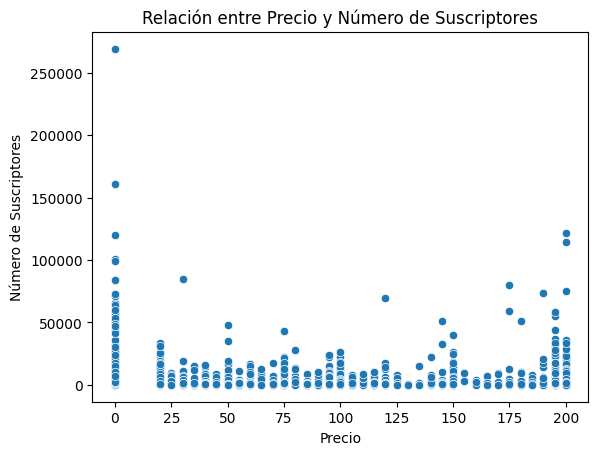

In [17]:
#Grafico Precio vs. Número de suscriptores en un gráfico de dispersión
sns.scatterplot(x='price', y='num_subscribers', data=cursos_udemy)
plt.xlabel('Precio')
plt.ylabel('Número de Suscriptores')
plt.title('Relación entre Precio y Número de Suscriptores')
plt.show()

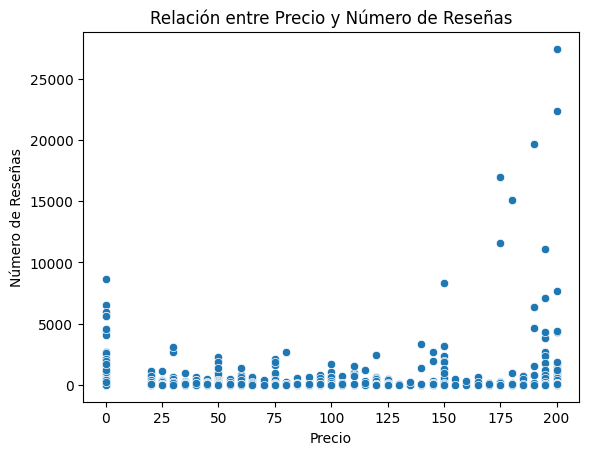

In [18]:
#Grafico Precio vs. Número de reseñas en un gráfico de dispersión
sns.scatterplot(x='price', y='num_reviews', data=cursos_udemy)
plt.xlabel('Precio')
plt.ylabel('Número de Reseñas')
plt.title('Relación entre Precio y Número de Reseñas')
plt.show()

In [19]:
#Veo la correlación entre Precio y Número de Suscriptores
correlacion_precio_suscriptores = cursos_udemy['price'].corr(cursos_udemy['num_subscribers'])

#Veo la correlación entre Precio y Número de Reseñas
correlacion_precio_resenas = cursos_udemy['price'].corr(cursos_udemy['num_reviews'])

print("Correlación entre Precio y Número de Suscriptores:", correlacion_precio_suscriptores)
print("Correlación entre Precio y Número de Reseñas:", correlacion_precio_resenas)

Correlación entre Precio y Número de Suscriptores: 0.05076934882586656
Correlación entre Precio y Número de Reseñas: 0.11369591938207214


In [20]:
#Veo la corrlación entre la duración del contenido y el número de suscriptores
correlacion_duracion_suscriptores = cursos_udemy['content_duration'].corr(cursos_udemy['num_subscribers'])

#Veo la corrlación entre la duración del contenido y el número de reseñas
correlacion_duracion_resenas = cursos_udemy['content_duration'].corr(cursos_udemy['num_reviews'])

print("Correlación entre Duración del Contenido y Número de Suscriptores:", correlacion_duracion_suscriptores)
print("Correlación entre Duración del Contenido y Número de Reseñas:", correlacion_duracion_resenas)


Correlación entre Duración del Contenido y Número de Suscriptores: 0.16183867741001337
Correlación entre Duración del Contenido y Número de Reseñas: 0.22888928805305014


<Figure size 1200x600 with 0 Axes>

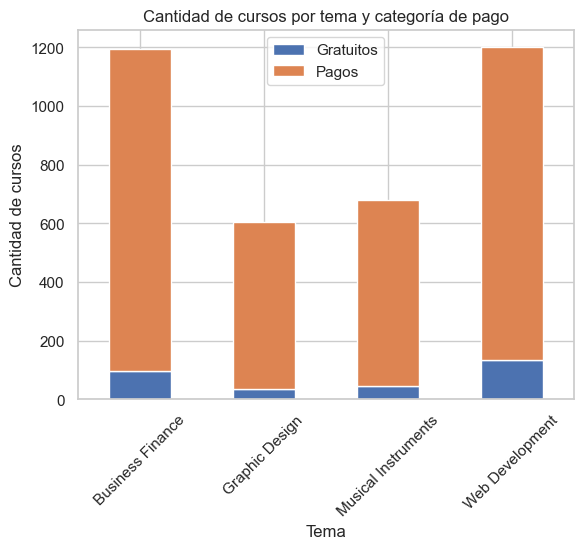

In [21]:
#Veo si hay relación entre los temas de los cursos y si son pagos o no

#Agrupo los cursos por tema y categoría de pago
course_counts = cursos_udemy.groupby(['subject', 'is_paid']).size().unstack()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
course_counts.plot(kind='bar', stacked=True)
plt.title("Cantidad de cursos por tema y categoría de pago")
plt.xlabel("Tema")
plt.ylabel("Cantidad de cursos")
plt.xticks(rotation=45)
plt.legend(["Gratuitos", "Pagos"])
plt.show()

In [22]:
#Veo si hay relación entre los temas de los cursos y tienen inscriptos o no

tabla_contingencia = pd.crosstab(cursos_udemy['subject'], cursos_udemy['num_subscribers'] > 0)
print(tabla_contingencia)

num_subscribers      False  True 
subject                          
Business Finance        40   1155
Graphic Design          19    584
Musical Instruments     11    669
Web Development          0   1200


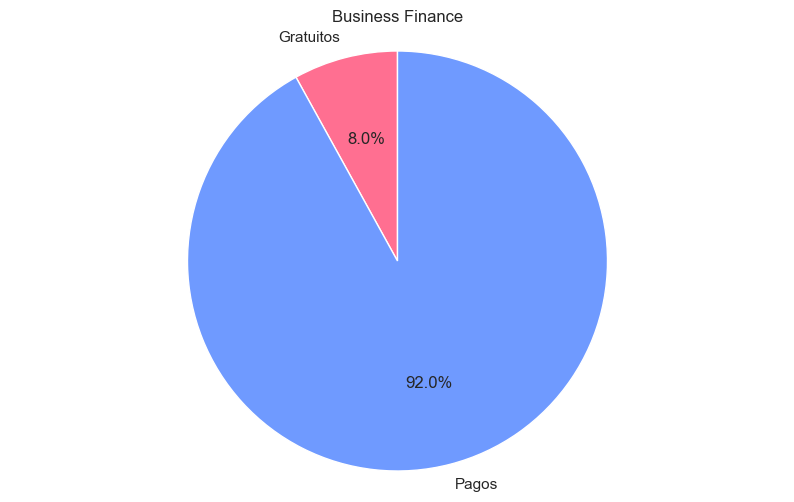

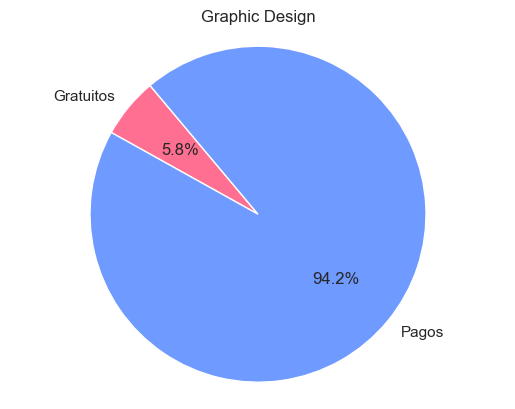

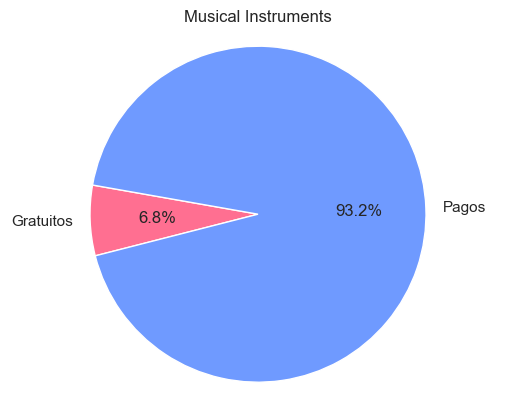

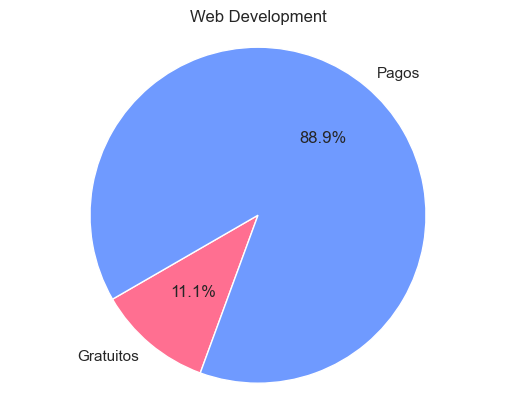

In [23]:
#Obtengo la proporción de cursos pagos y gratuitos por tema
course_prop = cursos_udemy.groupby(['subject', 'is_paid']).size().unstack() / len(cursos_udemy)

plt.figure(figsize=(10, 6))
colors = ['#FF6F91', '#6F9AFF']
labels = ['Gratuitos', 'Pagos']
for i, subject in enumerate(course_prop.index):
    plt.pie(course_prop.loc[subject], labels=labels, autopct='%1.1f%%', colors=colors, startangle=90 + i * 40)
    plt.title(subject)
    plt.axis('equal')
    plt.show()

In [24]:
# Frecuencia de temas para cursos pagos
freq_paid = cursos_udemy.loc[cursos_udemy['is_paid'] == True, 'subject'].value_counts()

# Frecuencia de temas para cursos gratuitos
freq_free = cursos_udemy.loc[cursos_udemy['is_paid'] == False, 'subject'].value_counts()

print("Frecuencia de temas para cursos pagos:")
print(freq_paid)

print("\nFrecuencia de temas para cursos gratuitos:")
print(freq_free)

Frecuencia de temas para cursos pagos:
Business Finance       1099
Web Development        1067
Musical Instruments     634
Graphic Design          568
Name: subject, dtype: int64

Frecuencia de temas para cursos gratuitos:
Web Development        133
Business Finance        96
Musical Instruments     46
Graphic Design          35
Name: subject, dtype: int64


In [25]:
# Crear tabla de contingencia entre temas y categoría de pago
contingency_table = pd.crosstab(cursos_udemy['subject'], cursos_udemy['is_paid'])

# Agregar una columna con la proporción de cursos pagos respecto al total por tema
contingency_table['Proporción Pagos'] = contingency_table[True] / (contingency_table[True] + contingency_table[False])

# Agregar una columna con la proporción de cursos gratuitos respecto al total por tema
contingency_table['Proporción Gratuitos'] = contingency_table[False] / (contingency_table[True] + contingency_table[False])

print(contingency_table)

is_paid              False  True  Proporción Pagos  Proporción Gratuitos
subject                                                                 
Business Finance        96  1099          0.919665              0.080335
Graphic Design          35   568          0.941957              0.058043
Musical Instruments     46   634          0.932353              0.067647
Web Development        133  1067          0.889167              0.110833


In [26]:
# Estadísticas descriptivas de los precios por tema
price_stats = cursos_udemy.groupby('subject')['price'].describe()
print(price_stats)

                      count       mean        std  min   25%   50%    75%  \
subject                                                                     
Business Finance     1195.0  68.552301  64.379824  0.0  20.0  45.0   95.0   
Graphic Design        603.0  57.827529  57.211708  0.0  20.0  30.0   80.0   
Musical Instruments   680.0  49.558824  41.187592  0.0  20.0  40.0   50.0   
Web Development      1200.0  77.033333  66.080477  0.0  20.0  50.0  115.0   

                       max  
subject                     
Business Finance     200.0  
Graphic Design       200.0  
Musical Instruments  200.0  
Web Development      200.0  


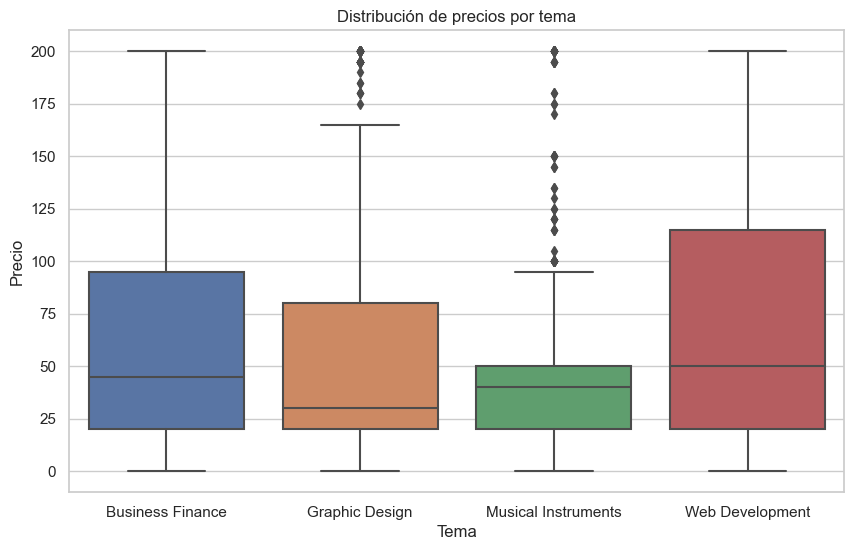

In [27]:
# Gráfico de caja de precios por tema
plt.figure(figsize=(10, 6))
sns.boxplot(x='subject', y='price', data=cursos_udemy)
plt.title('Distribución de precios por tema')
plt.xlabel('Tema')
plt.ylabel('Precio')
plt.show()

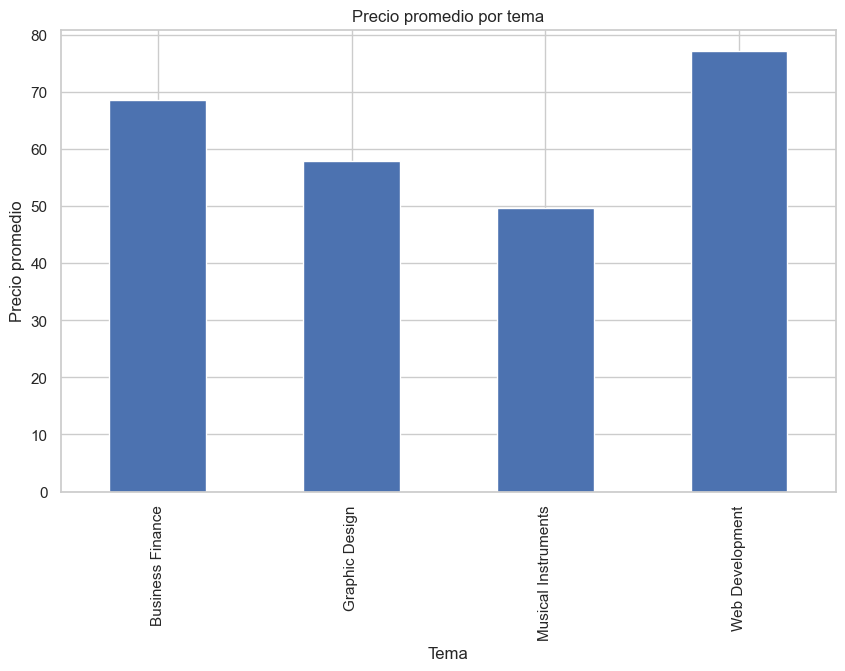

In [28]:
# Precio promedio por tema
mean_price_by_subject = cursos_udemy.groupby('subject')['price'].mean()

# Gráfico de barras de precios promedio por tema
plt.figure(figsize=(10, 6))
mean_price_by_subject.plot(kind='bar')
plt.title('Precio promedio por tema')
plt.xlabel('Tema')
plt.ylabel('Precio promedio')
plt.show()

                         price        num_subscribers        
                          mean median            mean  median
subject                                                      
Business Finance     68.552301   45.0     1563.774895   484.0
Graphic Design       57.827529   30.0     1763.097844   384.0
Musical Instruments  49.558824   40.0     1245.130882   138.0
Web Development      77.033333   50.0     6650.476667  2416.5


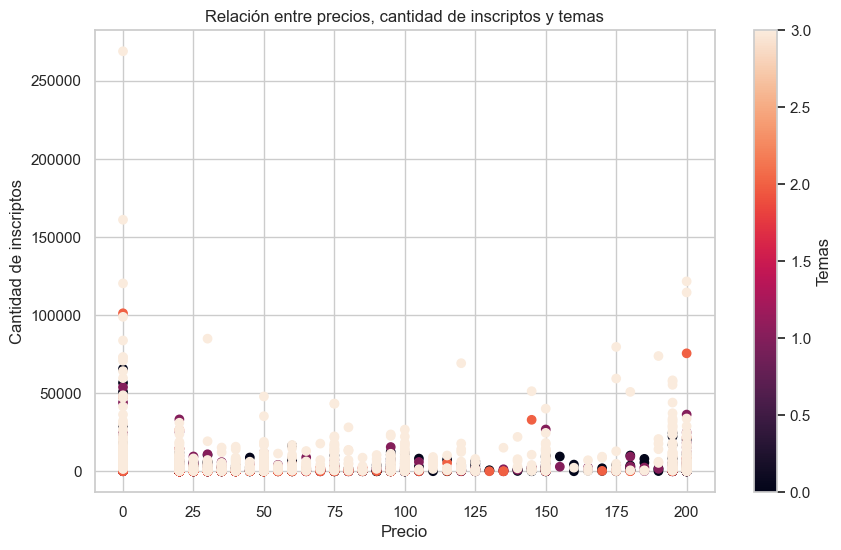

Correlación entre precios y cantidad de inscriptos: 0.05076934882586656


In [29]:
# Estadísticas descriptivas de precios y cantidad de inscriptos por tema
stats_by_subject = cursos_udemy.groupby('subject').agg({'price': ['mean', 'median'], 'num_subscribers': ['mean', 'median']})
print(stats_by_subject)

# Gráfico de dispersión de precios y cantidad de inscriptos por tema
plt.figure(figsize=(10, 6))
plt.scatter(cursos_udemy['price'], cursos_udemy['num_subscribers'], c=cursos_udemy['subject'].astype('category').cat.codes)
plt.title('Relación entre precios, cantidad de inscriptos y temas')
plt.xlabel('Precio')
plt.ylabel('Cantidad de inscriptos')
plt.colorbar(label='Temas')
plt.show()

# Correlación entre precios y cantidad de inscriptos
correlation = cursos_udemy['price'].corr(cursos_udemy['num_subscribers'])
print('Correlación entre precios y cantidad de inscriptos:', correlation)


                                               mean  median  count
subject             level                                         
Business Finance    All Levels          1504.609195   568.5    696
                    Beginner Level      1902.961765   474.5    340
                    Expert Level         972.451613   540.0     31
                    Intermediate Level  1127.734375   151.0    128
Graphic Design      All Levels          2309.838926   489.5    298
                    Beginner Level      1299.411523   276.0    243
                    Expert Level         201.600000    20.0      5
                    Intermediate Level  1018.438596   238.0     57
Musical Instruments All Levels          1189.021739   119.0    276
                    Beginner Level      1449.425676   138.0    296
                    Expert Level         775.857143    65.0      7
                    Intermediate Level   832.257426   181.0    101
Web Development     All Levels          7361.708649  2244.0   

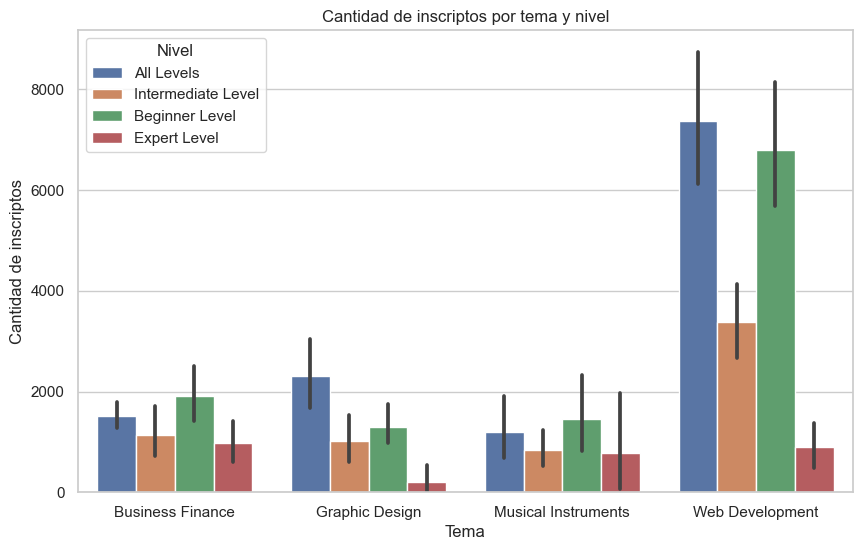

In [30]:
#Reviso la relación entre cantidad de inscriptos, temas y nivel de los cursos
grouped_data = cursos_udemy.groupby(['subject', 'level'])

stats_by_subject_level = grouped_data['num_subscribers'].agg(['mean', 'median', 'count'])
print(stats_by_subject_level)

#Gráfico de barras de la cantidad de inscriptos por tema y nivel
plt.figure(figsize=(10, 6))
sns.barplot(x='subject', y='num_subscribers', hue='level', data=cursos_udemy)
plt.title('Cantidad de inscriptos por tema y nivel')
plt.xlabel('Tema')
plt.ylabel('Cantidad de inscriptos')
plt.legend(title='Nivel')
plt.show()

                    content_duration        num_subscribers        
                                mean median            mean  median
subject                                                            
Business Finance            3.552999    2.0     1563.774895   484.0
Graphic Design              3.580542    2.0     1763.097844   384.0
Musical Instruments         2.854387    2.0     1245.130882   138.0
Web Development             5.594792    3.0     6650.476667  2416.5


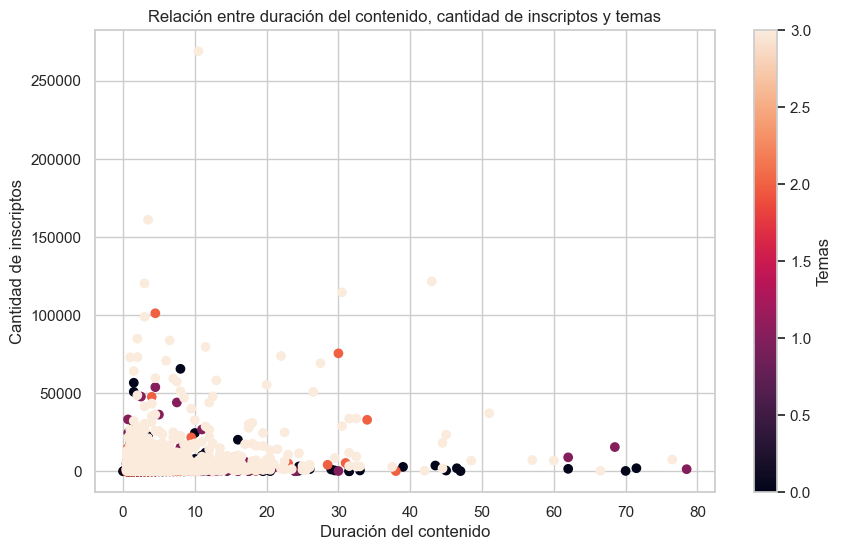

In [31]:
grouped_data = cursos_udemy.groupby('subject')

stats_by_subject = grouped_data.agg({'content_duration': ['mean', 'median'], 'num_subscribers': ['mean', 'median']})
print(stats_by_subject)

# Gráfico de dispersión de duración del contenido y cantidad de inscriptos por tema
plt.figure(figsize=(10, 6))
plt.scatter(cursos_udemy['content_duration'], cursos_udemy['num_subscribers'], c=cursos_udemy['subject'].astype('category').cat.codes)
plt.title('Relación entre duración del contenido, cantidad de inscriptos y temas')
plt.xlabel('Duración del contenido')
plt.ylabel('Cantidad de inscriptos')
plt.colorbar(label='Temas')
plt.show()

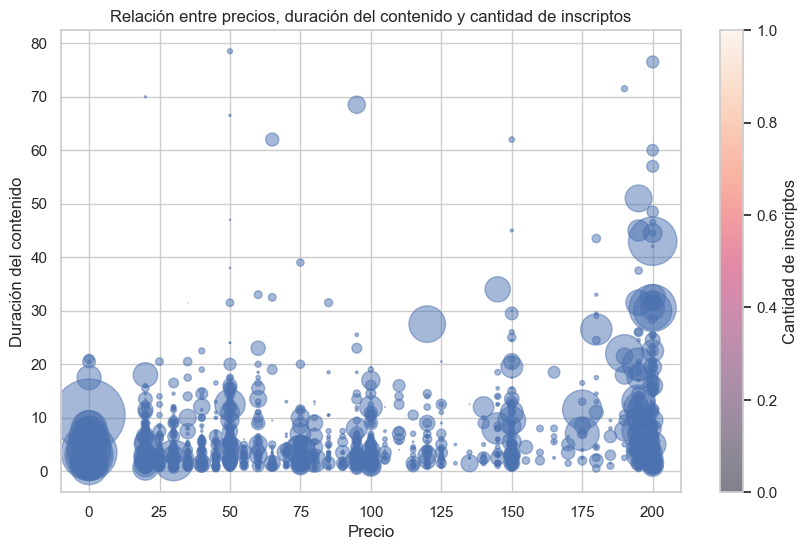

Correlación entre precios y duración del contenido: 0.2934496199015486
Correlación entre precios y cantidad de inscriptos: 0.05076934882586656
Correlación entre duración del contenido y cantidad de inscriptos: 0.16183867741001337


In [32]:
# Gráfico de dispersión de precios, duración del contenido y cantidad de inscriptos
plt.figure(figsize=(10, 6))
plt.scatter(cursos_udemy['price'], cursos_udemy['content_duration'], s=cursos_udemy['num_subscribers']/100, alpha=0.5)
plt.title('Relación entre precios, duración del contenido y cantidad de inscriptos')
plt.xlabel('Precio')
plt.ylabel('Duración del contenido')
plt.colorbar(label='Cantidad de inscriptos')
plt.show()

# Correlación entre precios, duración del contenido y cantidad de inscriptos
correlation_price_duration = cursos_udemy['price'].corr(cursos_udemy['content_duration'])
correlation_price_subscribers = cursos_udemy['price'].corr(cursos_udemy['num_subscribers'])
correlation_duration_subscribers = cursos_udemy['content_duration'].corr(cursos_udemy['num_subscribers'])

print('Correlación entre precios y duración del contenido:', correlation_price_duration)
print('Correlación entre precios y cantidad de inscriptos:', correlation_price_subscribers)
print('Correlación entre duración del contenido y cantidad de inscriptos:', correlation_duration_subscribers)

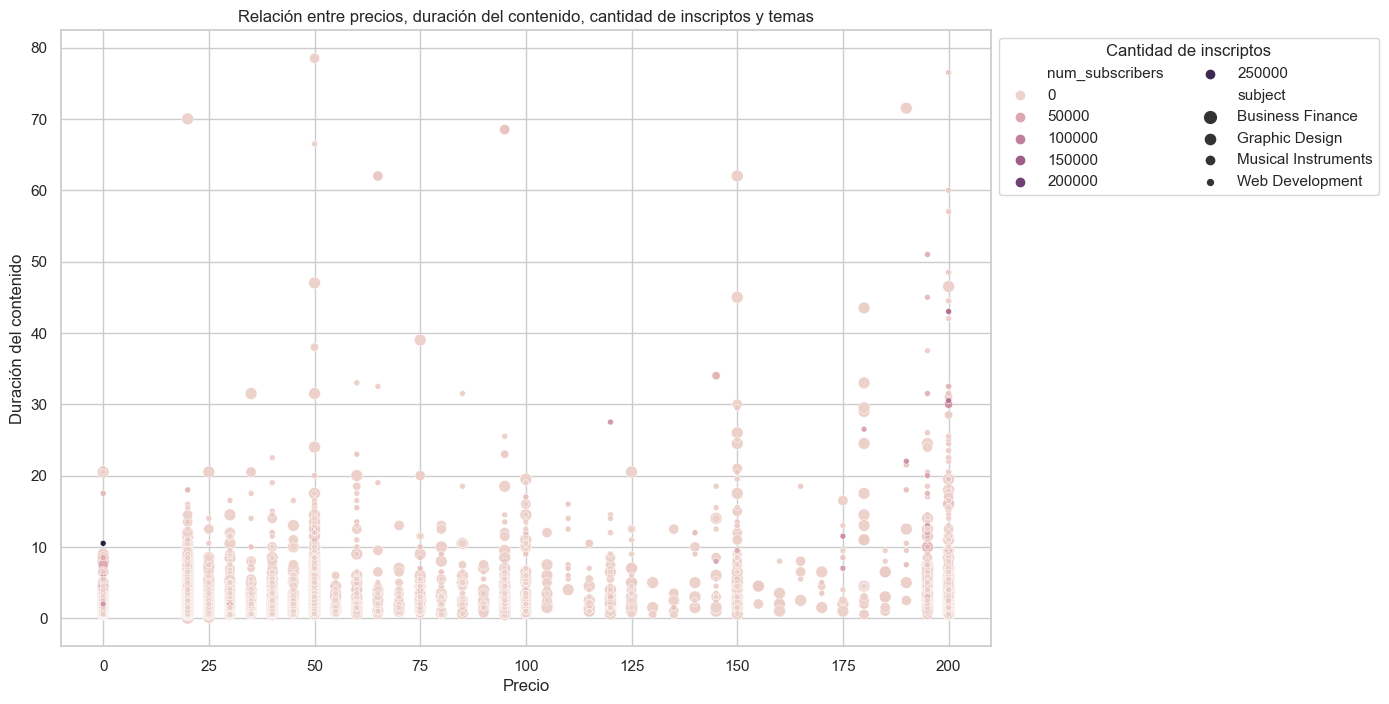

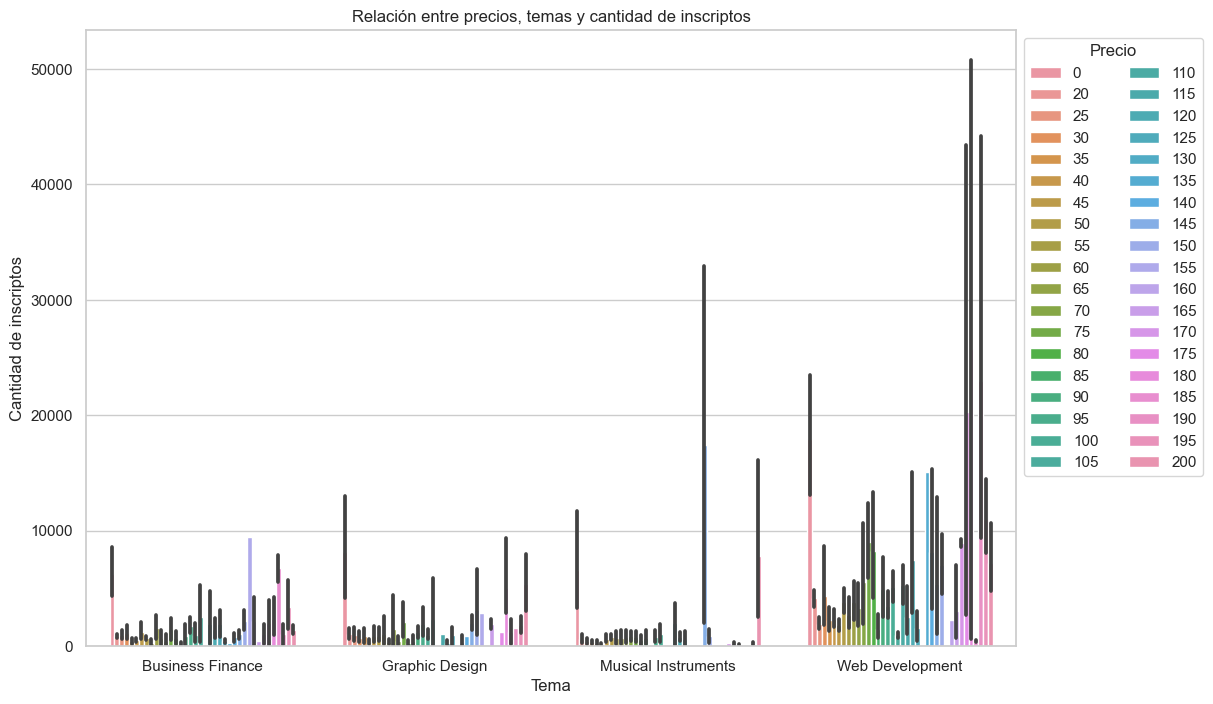

Correlación entre precios y duración del contenido: 0.2934496199015486
Correlación entre precios y cantidad de inscriptos: 0.05076934882586656
Correlación entre duración del contenido y cantidad de inscriptos: 0.16183867741001337


In [33]:
# Gráfico de dispersión de precios, duración del contenido, cantidad de inscriptos y temas
plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='content_duration', hue='num_subscribers', size='subject', data=cursos_udemy)
plt.title('Relación entre precios, duración del contenido, cantidad de inscriptos y temas')
plt.xlabel('Precio')
plt.ylabel('Duración del contenido')
plt.legend(title='Cantidad de inscriptos', loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.show()

# Gráfico de barras de precios y cantidad de inscriptos por tema
plt.figure(figsize=(12, 8))
sns.barplot(x='subject', y='num_subscribers', hue='price', data=cursos_udemy)
plt.title('Relación entre precios, temas y cantidad de inscriptos')
plt.xlabel('Tema')
plt.ylabel('Cantidad de inscriptos')
plt.legend(title='Precio', loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.show()

# Correlación entre precios, duración del contenido, cantidad de inscriptos y temas
correlation_price_duration = cursos_udemy['price'].corr(cursos_udemy['content_duration'])
correlation_price_subscribers = cursos_udemy['price'].corr(cursos_udemy['num_subscribers'])
correlation_duration_subscribers = cursos_udemy['content_duration'].corr(cursos_udemy['num_subscribers'])

print('Correlación entre precios y duración del contenido:', correlation_price_duration)
print('Correlación entre precios y cantidad de inscriptos:', correlation_price_subscribers)
print('Correlación entre duración del contenido y cantidad de inscriptos:', correlation_duration_subscribers)

year
2011     119028
2012     555339
2013    1723438
2014    1930406
2015    3475324
2016    2966644
2017     988941
Name: num_subscribers, dtype: int64


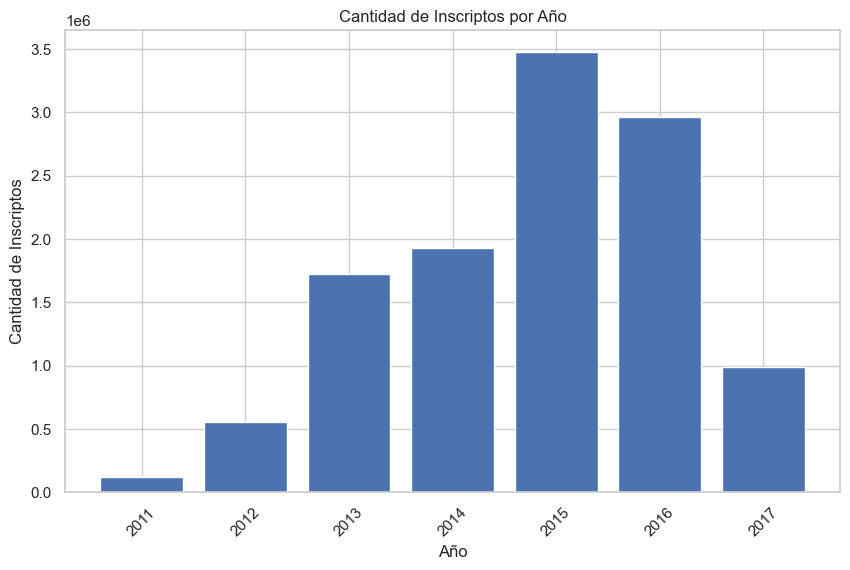

In [34]:
inscriptos_por_anio = cursos_udemy.groupby(cursos_udemy['year'])['num_subscribers'].sum().sort_index()
print(inscriptos_por_anio)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(inscriptos_por_anio.index, inscriptos_por_anio.values)
plt.xlabel('Año')
plt.ylabel('Cantidad de Inscriptos')
plt.title('Cantidad de Inscriptos por Año')
plt.xticks(rotation=45)
plt.show()

                subject  year  num_subscribers
0      Business Finance  2012             3620
1      Business Finance  2013           311664
2      Business Finance  2014           494623
3      Business Finance  2015           501858
4      Business Finance  2016           426647
5      Business Finance  2017           130299
6        Graphic Design  2012           100649
7        Graphic Design  2013            50133
8        Graphic Design  2014           174582
9        Graphic Design  2015           352856
10       Graphic Design  2016           229587
11       Graphic Design  2017           155341
12  Musical Instruments  2012           133635
13  Musical Instruments  2013           150224
14  Musical Instruments  2014           156152
15  Musical Instruments  2015           190368
16  Musical Instruments  2016           148748
17  Musical Instruments  2017            67562
18      Web Development  2011           119028
19      Web Development  2012           317435
20      Web D

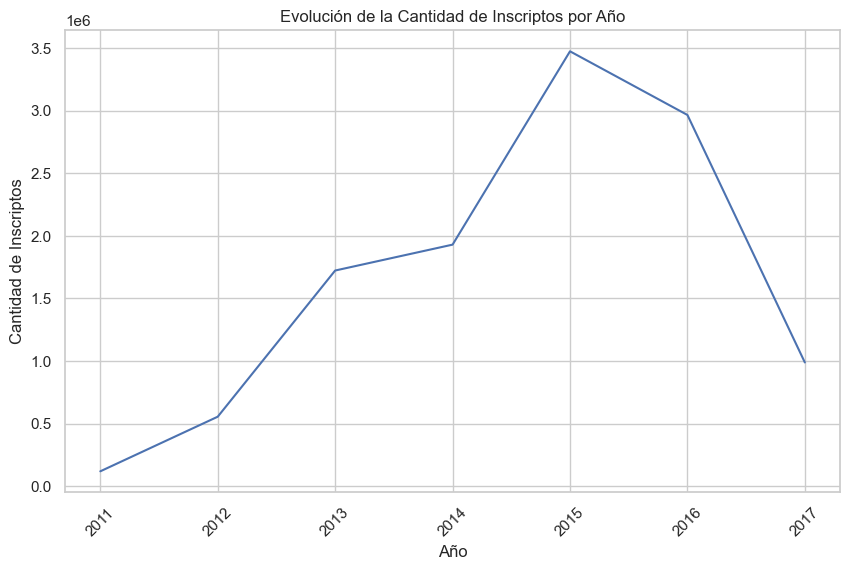

In [35]:
inscriptos_por_curso_y_anio = cursos_udemy.groupby(['subject', 'year'])['num_subscribers'].sum().reset_index()
print(inscriptos_por_curso_y_anio)

# Filtrar los datos de un curso específico (reemplaza 'course_id' con el identificador del curso deseado)
inscriptos_por_anio = cursos_udemy.groupby('year')['num_subscribers'].sum().reset_index()

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(inscriptos_por_anio['year'], inscriptos_por_anio['num_subscribers'])
plt.xlabel('Año')
plt.ylabel('Cantidad de Inscriptos')
plt.title('Evolución de la Cantidad de Inscriptos por Año')
plt.xticks(rotation=45)
plt.show()

In [38]:
#¿Se dictaron los mismos cursos todos los años?

q_cursos_por_anio = cursos_udemy.groupby('year')['course_id'].nunique()
print(q_cursos_por_anio)

pd.set_option('display.max_colwidth', None)

cursos_por_anio = cursos_udemy.groupby('year')['subject'].apply(lambda x: ', '.join(x.unique()))
print(cursos_por_anio)


year
2011       5
2012      45
2013     201
2014     490
2015    1014
2016    1204
2017     713
Name: course_id, dtype: int64
year
2011                                                           Web Development
2012    Business Finance, Graphic Design, Musical Instruments, Web Development
2013    Business Finance, Graphic Design, Musical Instruments, Web Development
2014    Business Finance, Graphic Design, Musical Instruments, Web Development
2015    Business Finance, Graphic Design, Musical Instruments, Web Development
2016    Business Finance, Graphic Design, Musical Instruments, Web Development
2017    Business Finance, Graphic Design, Musical Instruments, Web Development
Name: subject, dtype: object


In [42]:
cursos_2015 = set(cursos_udemy[cursos_udemy['year'] == 2015]['course_title'].unique())
cursos_2017 = set(cursos_udemy[cursos_udemy['year'] == 2017]['course_title'].unique())

diferencia_cursos = cursos_2015 - cursos_2017
print(diferencia_cursos)
print(len(diferencia_cursos))


{'Create a PHP Contact Form in Bootstrap', 'How to illustrate in Flash ', 'TRADING TACTICS', 'Your First Course on Piano', 'Curso Completo del Mercado FOREX', 'Guitar for Beginners - Learn the Basics', 'JavaScript Step by Step how to apply it to your web pages', 'French Horn Solos: Learn how to Perform Three Fun Pieces!', 'Guitar Super System Level 1', 'Building a Portfolio in 90 minutes ( HTML, CSS, Js ) ', 'Curso básico de Gimp; software gratis de diseño gráfico', 'jQuery for Beginners', 'Learn UI/UX and Mobile App Design in Photoshop from Scratch', 'Voiceover Audio Secrets - Your Way to Top Audio Quality', 'Fundraise the Simplified Way: A Crowdfunding Blueprint', 'CFA® Level 1 2014 – FI', 'Instant Harmonica - play Amazing Grace with grace and ease!', 'JavaScript for beginners with live examples', 'Venture Capital. What is it and Why it Matters to You!', 'Year-end QuickBooks Procedures', 'Essentials of Finance and Investment in 2 hours', 'Introduction to Equity Markets', 'Photoshop t

In [88]:
cursos_udemy.head(1)

course_id                        course_title  is_paid  price  \
0    1070968  Ultimate Investment Banking Course     True    200   

   num_subscribers  num_reviews  num_lectures       level  content_duration  \
0             2147           23            51  All Levels               1.5   

            subject  year  month  
0  Business Finance  2017      1

Conclusiones:
* Hubo un descenso en la cantidad de inscriptos del año 2015 al 2016, sin embargo la oferta de cursos en cantidad aumentó. El descenso puede deberse a:
    -Cambios en la oferta de cursos: Puede haber habido cambios en la cantidad o el tipo de cursos ofrecidos de un año a otro. Si la oferta de cursos en 2016 fue menor o menos atractiva para los estudiantes, podría haber llevado a una disminución en la cantidad de inscriptos.
    - Cambios en las estrategias de marketing: Las estrategias de marketing utilizadas para promocionar los cursos pueden haber cambiado de un año a otro. Si las campañas de marketing en 2016 no fueron tan efectivas como en 2015, es posible que haya tenido un impacto en la cantidad de personas que se inscribieron.
    - Cambios económicos: Factores económicos, como la situación económica general o la disponibilidad de recursos financieros de los estudiantes, podrían haber influido en la decisión de inscribirse en cursos. Si hubo cambios económicos desfavorables en 2016 en comparación con 2015, esto podría haber llevado a una disminución en los inscriptos.
    - Competencia en el mercado: El mercado de cursos en línea es altamente competitivo, y es posible que haya habido una mayor competencia de otros proveedores de cursos en 2016. Si los estudiantes tuvieron más opciones disponibles en el mercado y optaron por cursos de otros proveedores, esto podría haber impactado en la cantidad de inscriptos en 2016.
* El curso más popular es gratuito, para todos los niveles, dura aproximadamente 10 hs, está dentro de la temática Web Development y se dictó en el año 2013. De los que le siguen 50% son gratuitos y 50% pagos, 70% son para todos los niveles, duran en promedio 13 hs aproximadamente, el 80% están dentro de la categoría. Web Development y el 20% en Musical Instruments, están repartidos casi equitativamente entre los años 2013, 2014 y 2015. Por otro lado, los cursos menos populares son todos pagos un 20% son para todos los niveles, 40% nivel principiante y el restante 40% nivel intermedio. el tema que genera menos suscriptors es Business Finance

* Hay 310 cursos gratuitos y 3.368 pagos

* Los cursos por año incrementaron hasta el 2016, con un descenso para el año 2017

* En cuanto a la duración en relación a los niveles, aquellos que son para todos los niveles tienen la mayor duración promedio de 5 hs aproximadamente	

* La mayoría de los suscritpores se encuentra entre el mayor precio y los cursos gratuitos. A diferencia de quienes dejan sus reseñas que en mayor parte son quienes pagaron el precio más elevado Pero no es una correlación muy elevada

* Los temas con mayoría de cursos son 'Business Finance' y 'Web Development'. Los inscritpos se distribuyen dentro de esas dos categorías mayoritariamente, seguidos por Musical Instruments y Graphic Design

* El precio máximo que se paga por cursos en cualquiera de los temas, es $200. El promedio más caro se lo lleva Web Development con $77, seguido de Business Finance con $69

* Business Finance es el tema con la mayor cantidad de inscriptos, 696. El nivel de cursos más común en este tema es "All Levels", seguido de "Beginner Level" y "Intermediate Level". Hay un número limitado de inscriptos en el nivel "Expert Level". Graphic Design es el segundo tema más común, con 298 inscriptos en total. Al igual que en Business Finance, el nivel de cursos más común en Graphic Design es "All Levels". Sin embargo, también hay una proporción significativa de cursos en "Beginner Level" y "Intermediate Level". Musical Instruments tiene 276 inscriptos en total, y nuevamente, "All Levels" es el nivel de cursos más común en este tema. También hay una cantidad considerable de cursos en "Beginner Level" e "Intermediate Level". Web Development es el tema con la menor cantidad de cursos, con 659 cursos en total. El nivel de cursos más común en este tema es "All Levels", seguido de "Beginner Level" y "Intermediate Level". Hay un número muy limitado de cursos en el nivel "Expert Level".

* Los cursos de Web Development tienden a tener precios más altos en comparación con los otros temas, y también tienen un mayor número promedio de suscriptores. Por otro lado, los cursos de Musical Instruments tienen precios más bajos y un número promedio de suscriptores menor en comparación con los otros temas. Estas diferencias pueden reflejar la demanda y el valor percibido de los cursos en cada tema.

* Los cursos de Web Development tienden a tener una duración de contenido más larga en comparación con los otros temas, y también tienen un mayor número promedio de suscriptores. Por otro lado, los cursos de Musical Instruments tienen una duración de contenido más corta y un número promedio de suscriptores menor en comparación con los otros temas. Estas diferencias pueden reflejar las preferencias de los estudiantes en términos de la duración del contenido y la temática de los cursos.

* Ofrecen los mismos subjects entre el año 2012 y 2017, pero en distintas cantidades de cursos. Por ejemplo, entre 2015 y 2017, redujeron en 1014 la cantidad.

* Se observa un aumento significativo en la cantidad de inscritos desde el año 2011 hasta el año 2015, con un pico de inscritos en 2015. A partir de 2016, se observa una disminución en el número de inscritos. 

* Distribución de suscriptores por año: 
	* En general, el número de suscriptores ha aumentado a lo largo de los años en todas las categorías de cursos.
	* El año 2015 muestra un pico notable en la cantidad de suscriptores en todas las categorías, seguido de una disminución gradual en los años siguientes.

  Distribución de suscriptores por tema:
	* El tema de "Web Development" tiene la mayor cantidad de suscriptores en todos los años.
	* "Business Finance" y "Graphic Design" también muestran una cantidad significativa de suscriptores, aunque en menor medida.
	* "Musical Instruments" tiene la menor cantidad de suscriptores en comparación con otros temas.

  Tendencias generales:
	* "Web Development" muestra un crecimiento constante en el número de suscriptores a lo largo de los años.
	* "Business Finance" y "Graphic Design" tuvieron un aumento inicial en los suscriptores, seguido de cierta estabilización o disminución en años posteriores.
	* "Musical Instruments" experimentó un crecimiento inicial, pero su número de suscriptores se ha mantenido relativamente estable o ha disminuido en los últimos años.

-------------------------------------------------
### WORD CLOUD TOTALIDAD DE CURSOS

In [3]:
coursera = pd.read_csv('Datasets/Coursera_courses.csv')
edx = pd.read_csv('Datasets/edx_courses.csv')
udemy = pd.read_csv('Datasets/udemy_courses.csv')

cursos_juntos = pd.DataFrame()
cursos_juntos['Títulos'] = pd.concat([coursera['name'],edx['title'],udemy['course_title']],ignore_index=True)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [5]:
wordcloud = WordCloud().generate(' '.join(cursos_juntos['Títulos']))  # Reemplaza 'titulos' con el nombre de la columna en tu DataFrame


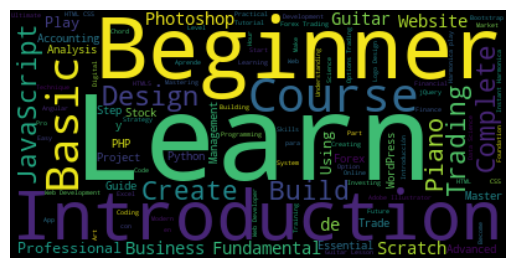

In [6]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
